# Proyecto Final Analítica de datos

Este proyecto de analítica se desarrolla a partir de la recolección de datos durante múltiples partidos de pádel, complementados con información de encuestas previas a cada encuentro. Los datos incluyen tanto variables cuantitativas del desempeño. Como desplazamientos, velocidad, aceleración y distancias recorridas en la cancha— como variables cualitativas relacionadas con la preparación física, la experiencia, el nivel de juego y la percepción del estado físico de cada jugador.

Se emplea un modelo supervisado con **XGBoost** para predecir el **estado físico declarado** de los jugadores a partir de sus métricas objetivas de rendimiento. Esto permite evaluar qué variables del desempeño tienen mayor influencia en la percepción del estado físico y generar predicciones confiables sobre cómo un jugador declarará su condición física, con base en datos cuantitativos reales.

El objetivo principal es analizar estos datos mediante técnicas de aprendizaje no supervisado, combinando **UMAP** para reducción de dimensionalidad y **K-Means** para identificación de clusters de rendimiento físico. Esta aproximación permite clasificar a los jugadores según su rendimiento real durante los partidos, sin depender únicamente de la autopercepción declarada. Además, se evalúa la coherencia entre el rendimiento real y el estado físico declarado, identificando casos de sobreestimación o subestimación.


A partir de los resultados obtenidos, se generan métricas de rendimiento individual y colectivo, se visualiza la evolución de los jugadores a lo largo del tiempo y se ofrecen recomendaciones personalizadas basadas en diferencias entre desempeño real y percibido. De esta manera, el proyecto proporciona una comprensión más profunda del rendimiento en pádel y ofrece información práctica para optimizar entrenamiento, mejorar la condición física y orientar estrategias de desarrollo individual.


## Carga de datasets y limpieza

Se cargan el dataset final de los videos de pádel y el dataset de los datos de los jugadores, y se realiza una limpieza básica de los nombres en ambos archivos. Esta limpieza consistió en convertirlos a texto, eliminar espacios y unificarlos en mayúsculas para asegurar una correcta unión entre las bases.

In [1]:
import pandas as pd

# Cargar datasets
df_videos = pd.read_excel("Base_Videos_Final.xlsx")
df_jugadores = pd.read_excel("Datos_Jugadores_Padel.xlsx")

# Crear columnas limpias
df_videos["player_name_clean"] = (
    df_videos["player_name"]
    .astype(str)
    .str.strip()
    .str.upper()
)

df_jugadores["NOMBRE_clean"] = (
    df_jugadores["NOMBRE"]
    .astype(str)
    .str.strip()
    .str.upper()
)

# Merge usando los nombres limpios
df_merge = df_videos.merge(
    df_jugadores[["NOMBRE_clean", "ESTADO_FISICO"]],
    left_on="player_name_clean",
    right_on="NOMBRE_clean",
    how="left"
)

# Crear tabla única
tabla_estado = (
    df_merge[["player_name", "ESTADO_FISICO"]]
    .drop_duplicates()
    .sort_values("player_name")
    .reset_index(drop=True)
)

tabla_estado


,player_name,ESTADO_FISICO
0,Andrea Julieth Sosa Rodriguez,Bueno
1,Carlos Felipe Andrade SÃ¡enz,NaN
2,Cristian Stevan Soto Zapata,Bueno
3,CÃ©sar Camilo DÃ­az CufiÃ±o,NaN
4,David Santiago Medina Buitrago,Bueno
...,...,...
327,Valentina Jimenez Gomez,Bueno
328,juan miguel venegas garzÃ³n,NaN
329,maria jose martinez villabona,NaN
330,sara juliana solano boada,Bueno


In [2]:
df_merge.head()
df_merge.shape

(540300, 33)

In [3]:
df_videos = df_merge.copy()

### Tabla de Jugadores Sin Información de Estado Físico

Se generó una tabla con los jugadores que no tenían información de estado físico tras la unión de los datasets.  
El proceso incluyó:

- Filtrar aquellos con valores faltantes.
- Eliminar duplicados.
- Ordenar los registros alfabéticamente.


In [4]:
jugadores_nan = (
    df_videos[df_videos["ESTADO_FISICO"].isna()][["player_name"]]
    .drop_duplicates()
    .sort_values("player_name")
)

jugadores_nan

,player_name
59801,Carlos Felipe Andrade SÃ¡enz
258740,CÃ©sar Camilo DÃ­az CufiÃ±o
527960,Fermin Alejandro Escalona Guillen
234271,Jaime Andres Castillo Alvarez
43205,Jorge Enrique Lugo Lopez
...,...
209610,Santiago Urrego RodrÃ­guez
113015,Sergio AndrÃ©s LÃ³pez RodrÃ­guez
460028,juan miguel venegas garzÃ³n
532091,maria jose martinez villabona


### Limpieza y Unificación de Nombres

Se realizó un proceso de limpieza avanzada de nombres que incluyó:

- Corregir caracteres mal codificados.
- Eliminar tildes.
- Normalizar espacios.
- Convertir a mayúsculas para estandarizar ambos datasets.

Luego, se unieron las bases de datos usando estos nombres limpios y se eliminaron duplicados generados por el merge, construyendo una **tabla de verificación** para comprobar que la correspondencia entre jugadores y sus datos fuera correcta.


In [5]:
import unicodedata
import pandas as pd
import re

def reparar_y_limpiar(nombre):
    if pd.isna(nombre):
        return ""
    
    # Convertir a string
    nombre = str(nombre)

    # 1. REPARAR caracteres mal codificados (caso Andrés → AndrÃ©s)
    try:
        nombre = nombre.encode('latin1').decode('utf-8')
    except:
        pass  # Si no aplica, sigue igual

    # 2. Eliminar tildes (María → MARIA)
    nombre = unicodedata.normalize('NFD', nombre)
    nombre = nombre.encode('ascii', 'ignore').decode('utf-8')

    # 3. Quitar caracteres raros y dobles espacios
    nombre = re.sub(r'\s+', ' ', nombre).strip()

    # 4. Pasar a mayúsculas
    nombre = nombre.upper()

    return nombre


In [6]:
df_videos["player_name_clean"] = df_videos["player_name"].apply(reparar_y_limpiar)
df_jugadores["NOMBRE_clean"] = df_jugadores["NOMBRE"].apply(reparar_y_limpiar)


In [7]:
df_merge = df_videos.merge(
    df_jugadores[["NOMBRE_clean", "ESTADO_FISICO", "FRECUENCIA_DEPORTE"]],
    left_on="player_name_clean",
    right_on="NOMBRE_clean",
    how="left"
)


In [8]:
# Eliminar columnas duplicadas del primer merge
df_merge = df_merge.drop(columns=[
    "NOMBRE_clean_x",
    "ESTADO_FISICO_x",
    "NOMBRE_clean_y"    # OJO: la vamos a reemplazar con la versión limpia de jugadores
], errors="ignore")

# Renombrar correctamente la columna que queremos
df_merge = df_merge.rename(columns={
    "ESTADO_FISICO_y": "ESTADO_FISICO"
})


### Tabla de Verificación de Jugadores

Se construyó una tabla de verificación con los primeros registros del dataset unificado, mostrando:

- Nombre original del jugador.
- Nombre limpio estandarizado.
- Variables de estado físico.
- Frecuencia de práctica deportiva.

Esta tabla permitió revisar manualmente si el proceso de emparejamiento entre ambos datasets se realizó correctamente y detectar posibles inconsistencias en la correspondencia de los jugadores.


In [9]:
tabla_verificacion = (
    df_merge[[
        "player_name",
        "player_name_clean",
        "ESTADO_FISICO",
        "FRECUENCIA_DEPORTE"
    ]]
    .drop_duplicates()
    .sort_values("player_name_clean")
    .head(40)
)

tabla_verificacion


,player_name,player_name_clean,ESTADO_FISICO,FRECUENCIA_DEPORTE
361951,NaN,,NaN,NaN
23839,Andrea Julieth Sosa Rodriguez,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,3-4 veces
59801,Carlos Felipe Andrade SÃ¡enz,CARLOS FELIPE ANDRADE SAENZ,NaN,NaN
263329,CÃ©sar Camilo DÃ­az CufiÃ±o,CESAR CAMILO DIAZ CUFINO,Bueno,Más de 4 veces
254167,Cristian Stevan Soto Zapata,CRISTIAN STEVAN SOTO ZAPATA,Bueno,3-4 veces
344210,David Santiago Medina Buitrago,DAVID SANTIAGO MEDINA BUITRAGO,Bueno,Más de 4 veces
224245,David Santiago Murcia Barrera,DAVID SANTIAGO MURCIA BARRERA,Regular,3-4 veces
535003,Fermin Alejandro Escalona Guillen,FERMIN ALEJANDRO ESCALONA GUILLEN,Excelente,Más de 4 veces
63395,Isabella Buitrago Hurtado,ISABELLA BUITRAGO HURTADO,Regular,1-2 veces
238860,Jaime Andres Castillo Alvarez,JAIME ANDRES CASTILLO ALVAREZ,NaN,NaN


### Depuración de Registros No Relevantes

Finalmente, se eliminaron del dataset aquellas filas cuyos nombres correspondían a etiquetas genéricas del tipo `Player_XX`, ya que no representan jugadores reales y podrían afectar el análisis. 

Esta depuración permitió conservar únicamente registros válidos, asegurando que la verificación posterior de los datos —incluyendo el estado físico y la frecuencia deportiva— se realizara sobre información confiable.


In [10]:
# Eliminar filas donde el nombre sea del tipo Player_XX
df_merge = df_merge[~df_merge["player_name_clean"].str.match(r"PLAYER_\d+$")]


In [11]:
tabla_verificacion = (
    df_merge[[
        "player_name",
        "player_name_clean",
        "ESTADO_FISICO",
        "FRECUENCIA_DEPORTE"
    ]]
    .drop_duplicates()
    .sort_values("player_name_clean")
    .head(40)
)

tabla_verificacion



,player_name,player_name_clean,ESTADO_FISICO,FRECUENCIA_DEPORTE
361951,NaN,,NaN,NaN
23839,Andrea Julieth Sosa Rodriguez,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,3-4 veces
59801,Carlos Felipe Andrade SÃ¡enz,CARLOS FELIPE ANDRADE SAENZ,NaN,NaN
263329,CÃ©sar Camilo DÃ­az CufiÃ±o,CESAR CAMILO DIAZ CUFINO,Bueno,Más de 4 veces
254167,Cristian Stevan Soto Zapata,CRISTIAN STEVAN SOTO ZAPATA,Bueno,3-4 veces
344210,David Santiago Medina Buitrago,DAVID SANTIAGO MEDINA BUITRAGO,Bueno,Más de 4 veces
224245,David Santiago Murcia Barrera,DAVID SANTIAGO MURCIA BARRERA,Regular,3-4 veces
535003,Fermin Alejandro Escalona Guillen,FERMIN ALEJANDRO ESCALONA GUILLEN,Excelente,Más de 4 veces
63395,Isabella Buitrago Hurtado,ISABELLA BUITRAGO HURTADO,Regular,1-2 veces
238860,Jaime Andres Castillo Alvarez,JAIME ANDRES CASTILLO ALVAREZ,NaN,NaN


### Generación de Claves de Coincidencia para Nombres

- Se identificaron los jugadores con valores *NaN* en **estado físico** o **frecuencia deportiva**.  
- Se generó una lista depurada de estos jugadores utilizando sus nombres originales y nombres limpios.  
- Se construyó un **catálogo de referencia** con los jugadores que sí tenían información completa y cuyos nombres ya estaban estandarizados.  
- Se definió una **función** para crear combinaciones de palabras (de 2 y 3 términos) a partir del nombre limpio de cada jugador.  
- Con esta función se generaron múltiples **claves de coincidencia** para cada jugador con datos faltantes.  
- Estas claves permitieron ampliar las posibilidades de emparejar nombres entre datasets, incluso cuando los nombres no coincidían exactamente.


In [12]:
# 1. Filtrar jugadores faltantes (con NaN)
faltantes = df_merge[
    df_merge["ESTADO_FISICO"].isna() | df_merge["FRECUENCIA_DEPORTE"].isna()
][["player_name", "player_name_clean"]].drop_duplicates()

faltantes


,player_name,player_name_clean
0,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO
625,Nicole Lizarazo,NICOLE LIZARAZO
1240,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO
43205,Jorge Enrique Lugo Lopez,JORGE ENRIQUE LUGO LOPEZ
43641,MarÃ­a JosÃ© Cifuentes,MARIA JOSE CIFUENTES
59801,Carlos Felipe Andrade SÃ¡enz,CARLOS FELIPE ANDRADE SAENZ
238860,Jaime Andres Castillo Alvarez,JAIME ANDRES CASTILLO ALVAREZ
239266,Nicolas Navarro,NICOLAS NAVARRO
326722,Santiago GutiÃ©rrez de PiÃ±eres Barbosa,SANTIAGO GUTIERREZ DE PINERES BARBOSA
361951,NaN,


In [13]:
# 2. Catálogo limpio de referencia
cat_ref = df_jugadores[["NOMBRE_clean", "ESTADO_FISICO", "FRECUENCIA_DEPORTE"]].drop_duplicates()

# --- FUNCIÓN: generar claves de 2 o 3 palabras ---
def clave_2words(name):
    if pd.isna(name) or name.strip() == "":
        return None
    parts = name.strip().split()
    if len(parts) < 2:
        return None
    combos = []
    for i in range(len(parts)-1):
        combos.append(parts[i] + " " + parts[i+1])
        if i < len(parts)-2:
            combos.append(parts[i] + " " + parts[i+1] + " " + parts[i+2])
    return combos


In [14]:
# 3. Expandir faltantes → múltiples claves posibles
expanded = []
for idx, row in faltantes.iterrows():
    claves = clave_2words(row["player_name_clean"])
    if claves:
        for c in claves:
            expanded.append([row["player_name"], row["player_name_clean"], c])

expanded_df = pd.DataFrame(expanded, columns=["player_name", "player_name_clean", "match_key"])

expanded_df.head(20)


,player_name,player_name_clean,match_key
0,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,LUIS JORGE
1,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,LUIS JORGE GARCIA
2,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,JORGE GARCIA
3,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,JORGE GARCIA CAMARGO
4,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,GARCIA CAMARGO
5,Nicole Lizarazo,NICOLE LIZARAZO,NICOLE LIZARAZO
6,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,NIKOL SOFIA
7,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,NIKOL SOFIA AVENDANO
8,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,SOFIA AVENDANO
9,Jorge Enrique Lugo Lopez,JORGE ENRIQUE LUGO LOPEZ,JORGE ENRIQUE


### Búsqueda y Consolidación de Coincidencias de Nombres

En esta etapa se implementó un procedimiento para buscar coincidencias utilizando las claves generadas:

- Se definió una **función** que localiza en el catálogo de referencia aquellos nombres que contienen la clave propuesta, sin distinguir mayúsculas o minúsculas.  
- Para cada combinación de claves obtenidas previamente, se buscó si existía uno o más jugadores cuyo **nombre limpio** coincidiera parcialmente.  
- Cuando se encontró una coincidencia, se registró la relación junto con el **estado físico** y la **frecuencia deportiva** provenientes del catálogo.  
- Finalmente, se consolidaron todas las coincidencias detectadas en un **DataFrame depurado**, evitando duplicados.


In [15]:
# 4. Buscar coincidencias por match_key
def buscar_match(clave):
    return cat_ref[cat_ref["NOMBRE_clean"].str.contains(clave, case=False, regex=False)]

matches = []
for idx, row in expanded_df.iterrows():
    cat = buscar_match(row["match_key"])
    if len(cat) > 0:
        for _, r in cat.iterrows():
            matches.append([
                row["player_name"],
                row["player_name_clean"],
                row["match_key"],
                r["NOMBRE_clean"],
                r["ESTADO_FISICO"],
                r["FRECUENCIA_DEPORTE"]
            ])

match_results = pd.DataFrame(matches, columns=[
    "player_name",
    "player_name_clean",
    "match_key",
    "matched_name",
    "ESTADO_FISICO",
    "FRECUENCIA_DEPORTE"
]).drop_duplicates()

match_results


,player_name,player_name_clean,match_key,matched_name,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,JORGE GARCIA,JORGE GARCIA CAMARGO,Regular,Más de 4 veces
1,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,JORGE GARCIA CAMARGO,JORGE GARCIA CAMARGO,Regular,Más de 4 veces
2,Luis Jorge Garcia Camargo,LUIS JORGE GARCIA CAMARGO,GARCIA CAMARGO,JORGE GARCIA CAMARGO,Regular,Más de 4 veces
3,Nicole Lizarazo,NICOLE LIZARAZO,NICOLE LIZARAZO,NICOLE LIZARAZO HERNANDEZ,Regular,0 veces
4,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,NIKOL SOFIA,NIKOL SOFIA AVENDANO SUAREZ,Regular,0 veces
5,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,NIKOL SOFIA AVENDANO,NIKOL SOFIA AVENDANO SUAREZ,Regular,0 veces
6,Nikol sofia avendaÃ±o,NIKOL SOFIA AVENDANO,SOFIA AVENDANO,NIKOL SOFIA AVENDANO SUAREZ,Regular,0 veces
7,MarÃ­a JosÃ© Cifuentes,MARIA JOSE CIFUENTES,MARIA JOSE,MARIA JOSE MARTINEZ VILLABONA,Bueno,Más de 4 veces
8,MarÃ­a JosÃ© Cifuentes,MARIA JOSE CIFUENTES,MARIA JOSE,MARIA JOSE CIFUENTES MARTINEZ,Regular,3-4 veces
9,MarÃ­a JosÃ© Cifuentes,MARIA JOSE CIFUENTES,MARIA JOSE,MARIA JOSE SANDOVAL RICAURTE,Regular,1-2 veces


### Integración de Coincidencias y Generación del Dataset Final

En la última etapa se integraron las coincidencias encontradas al **DataFrame principal** para completar la información faltante:

- Se realizó un **merge** entre el dataset original y los resultados de coincidencias, usando el **nombre limpio** como clave.  
- Los valores faltantes de **ESTADO_FISICO** y **FRECUENCIA_DEPORTE** fueron reemplazados por los valores corregidos obtenidos durante el proceso de emparejamiento.  
- Se eliminaron las columnas auxiliares generadas durante la fusión.  
- Se generó una **tabla final depurada**, ordenada y sin duplicados, que contiene el estado físico y la frecuencia deportiva correctamente asociados a cada jugador.


In [16]:
# 5. Unir matches al df principal
df_merge_fixed = df_merge.merge(
    match_results[["player_name_clean", "ESTADO_FISICO", "FRECUENCIA_DEPORTE"]],
    on="player_name_clean",
    how="left",
    suffixes=("", "_fix")
)

# Reemplazar NaN
for col in ["ESTADO_FISICO", "FRECUENCIA_DEPORTE"]:
    df_merge_fixed[col] = df_merge_fixed[col].fillna(df_merge_fixed[f"{col}_fix"])

df_merge_fixed = df_merge_fixed.drop(columns=["ESTADO_FISICO_fix", "FRECUENCIA_DEPORTE_fix"])


In [17]:
tabla_estado_final = (
    df_merge_fixed[[  # ← usa el df corregido
        "player_name",
        "player_name_clean",
        "ESTADO_FISICO",
        "FRECUENCIA_DEPORTE"
    ]]
    .drop_duplicates()
    .sort_values("player_name_clean")
    .reset_index(drop=True)
)

tabla_estado_final


,player_name,player_name_clean,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,NaN,,NaN,NaN
1,Andrea Julieth Sosa Rodriguez,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,3-4 veces
2,Carlos Felipe Andrade SÃ¡enz,CARLOS FELIPE ANDRADE SAENZ,NaN,NaN
3,CÃ©sar Camilo DÃ­az CufiÃ±o,CESAR CAMILO DIAZ CUFINO,Bueno,Más de 4 veces
4,Cristian Stevan Soto Zapata,CRISTIAN STEVAN SOTO ZAPATA,Bueno,3-4 veces
5,David Santiago Medina Buitrago,DAVID SANTIAGO MEDINA BUITRAGO,Bueno,Más de 4 veces
6,David Santiago Murcia Barrera,DAVID SANTIAGO MURCIA BARRERA,Regular,3-4 veces
7,Fermin Alejandro Escalona Guillen,FERMIN ALEJANDRO ESCALONA GUILLEN,Excelente,Más de 4 veces
8,Isabella Buitrago Hurtado,ISABELLA BUITRAGO HURTADO,Regular,1-2 veces
9,Jaime Andres Castillo Alvarez,JAIME ANDRES CASTILLO ALVAREZ,NaN,NaN


In [18]:
tabla_estado_final = (
    df_merge_fixed
    .sort_values("player_name_clean")
    .drop_duplicates(subset=["player_name_clean"])   # 👈 conservar 1 jugador único
    [["player_name", "player_name_clean", "ESTADO_FISICO", "FRECUENCIA_DEPORTE"]]
    .reset_index(drop=True)
)

tabla_estado_final


,player_name,player_name_clean,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,NaN,,NaN,NaN
1,Andrea Julieth Sosa Rodriguez,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,3-4 veces
2,Carlos Felipe Andrade SÃ¡enz,CARLOS FELIPE ANDRADE SAENZ,NaN,NaN
3,CÃ©sar Camilo DÃ­az CufiÃ±o,CESAR CAMILO DIAZ CUFINO,Bueno,Más de 4 veces
4,Cristian Stevan Soto Zapata,CRISTIAN STEVAN SOTO ZAPATA,Bueno,3-4 veces
5,David Santiago Medina Buitrago,DAVID SANTIAGO MEDINA BUITRAGO,Bueno,Más de 4 veces
6,David Santiago Murcia Barrera,DAVID SANTIAGO MURCIA BARRERA,Regular,3-4 veces
7,Fermin Alejandro Escalona Guillen,FERMIN ALEJANDRO ESCALONA GUILLEN,Excelente,Más de 4 veces
8,Isabella Buitrago Hurtado,ISABELLA BUITRAGO HURTADO,Regular,1-2 veces
9,Jaime Andres Castillo Alvarez,JAIME ANDRES CASTILLO ALVAREZ,NaN,NaN


### Corrección Final y Creación del Dataset Depurado

Antes de realizar la corrección final:

- Se filtraron las filas cuyo `player_name_clean` aparecía como `"NAN"`, eliminando registros inválidos.  
- El **DataFrame original** se unió con los resultados de coincidencias (`match_results`) usando `player_name_clean` como clave, incorporando valores corregidos de **ESTADO_FISICO** y **FRECUENCIA_DEPORTE**.  
- Si estos campos seguían vacíos, se completaron con las columnas provenientes del merge (`*_fix`).  
- Finalmente, se eliminaron las columnas auxiliares utilizadas para la corrección, dejando un **DataFrame limpio** (`df_merge_fixed`) en el que cada jugador posee la mejor información disponible derivada del proceso de emparejamiento.


In [19]:
df_merge = df_merge[df_merge["player_name_clean"].str.upper() != "NAN"]


In [20]:
df_merge_fixed = df_merge.merge(
    match_results[["player_name_clean", "ESTADO_FISICO", "FRECUENCIA_DEPORTE"]],
    on="player_name_clean",
    how="left",
    suffixes=("", "_fix")
)

for col in ["ESTADO_FISICO", "FRECUENCIA_DEPORTE"]:
    df_merge_fixed[col] = df_merge_fixed[col].fillna(df_merge_fixed[f"{col}_fix"])

df_merge_fixed = df_merge_fixed.drop(columns=["ESTADO_FISICO_fix", "FRECUENCIA_DEPORTE_fix"])


In [21]:
df_merge_fixed.head()

,frame_idx,duration,total_frames,video_duration,player_id,player_name,team,zone,ball_position_x,ball_position_y,...,ball_position_x_prev,ball_position_y_prev,ball_displacement,ball_speed_mps,time_since_last_hit,partido,punto,player_name_clean,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,0,0.033333,625,20.833333,1,Luis Jorge Garcia Camargo,top,right_box,3.24,17.111111,...,NaN,NaN,NaN,NaN,NaN,Partido 27,10.0,LUIS JORGE GARCIA CAMARGO,Regular,Más de 4 veces
1,0,0.033333,625,20.833333,1,Luis Jorge Garcia Camargo,top,right_box,3.24,17.111111,...,NaN,NaN,NaN,NaN,NaN,Partido 27,10.0,LUIS JORGE GARCIA CAMARGO,Regular,Más de 4 veces
2,0,0.033333,625,20.833333,1,Luis Jorge Garcia Camargo,top,right_box,3.24,17.111111,...,NaN,NaN,NaN,NaN,NaN,Partido 27,10.0,LUIS JORGE GARCIA CAMARGO,Regular,Más de 4 veces
3,1,0.033333,625,20.833333,1,Luis Jorge Garcia Camargo,top,right_box,3.24,17.111111,...,NaN,NaN,NaN,NaN,NaN,Partido 27,10.0,LUIS JORGE GARCIA CAMARGO,Regular,Más de 4 veces
4,1,0.033333,625,20.833333,1,Luis Jorge Garcia Camargo,top,right_box,3.24,17.111111,...,NaN,NaN,NaN,NaN,NaN,Partido 27,10.0,LUIS JORGE GARCIA CAMARGO,Regular,Más de 4 veces


In [22]:
df_merge_fixed.shape

(475657, 33)

## Variables a trabajar

Aqui se observan las variables del dataset final 

In [23]:
pd.set_option('display.max_columns', None)
df_merge_fixed.columns


Index(['frame_idx', 'duration', 'total_frames', 'video_duration', 'player_id',
       'player_name', 'team', 'zone', 'ball_position_x', 'ball_position_y',
       'player_position_x', 'player_position_y', 'distance_ball_to_net',
       'distance_player_to_ball_m', 'distance_player_to_net_m',
       'distance_player_to_teammate_m', 'player_hits_ball', 'prev_x', 'prev_y',
       'player_displacement', 'player_speed_mps', 'prev_speed',
       'player_acceleration_mps2', 'ball_position_x_prev',
       'ball_position_y_prev', 'ball_displacement', 'ball_speed_mps',
       'time_since_last_hit', 'partido', 'punto', 'player_name_clean',
       'ESTADO_FISICO', 'FRECUENCIA_DEPORTE'],
      dtype='object')

Se eliminan las que no son relevantes

In [24]:
# Columnas que se eliminan del dataframe final para el modelo
cols_to_drop = [
    "frame_idx",
    "player_id",
    "team",
    "NOMBRE_clean",
    "prev_x", "prev_y",
    "ball_position_x_prev", "ball_position_y_prev",
    "ball_position_x", "ball_position_y",
    "player_position_x", "player_position_y"
]

df_clean = df_merge_fixed.drop(columns=cols_to_drop, errors='ignore')

df_clean.shape, df_clean.columns


((475657, 22),
 Index(['duration', 'total_frames', 'video_duration', 'player_name', 'zone',
        'distance_ball_to_net', 'distance_player_to_ball_m',
        'distance_player_to_net_m', 'distance_player_to_teammate_m',
        'player_hits_ball', 'player_displacement', 'player_speed_mps',
        'prev_speed', 'player_acceleration_mps2', 'ball_displacement',
        'ball_speed_mps', 'time_since_last_hit', 'partido', 'punto',
        'player_name_clean', 'ESTADO_FISICO', 'FRECUENCIA_DEPORTE'],
       dtype='object'))

### Estadísticas Resumidas por Jugador y Partido

En este paso se calcularon estadísticas resumidas para cada jugador en cada partido:

- Se seleccionaron las métricas **numéricas relevantes** de desempeño.  
- Se calcularon medidas **promedio** por jugador y por partido, obteniendo indicadores representativos de cada encuentro.  
- Se sumaron métricas acumulativas, como la cantidad total de golpes (`player_hits_ball`).  
- El resultado es una **tabla resumen** (`df_partido`) donde cada fila refleja el desempeño de un jugador en un partido específico, facilitando análisis comparativos y evaluaciones individuales.


In [25]:
# 1. Seleccionar métricas numéricas relevantes para promediar por jugador/partido
metricas = [
    "player_displacement",
    "player_speed_mps",
    "player_acceleration_mps2",
    "distance_player_to_ball_m",
    "distance_player_to_net_m",
    "distance_player_to_teammate_m",
    "ball_speed_mps",
    "ball_displacement",
    "distance_ball_to_net",
    "time_since_last_hit",
    "duration",
    "total_frames",
    "video_duration",
    "punto"
]

# 2. Además, sumar hits (actividad)
metricas_sum = ["player_hits_ball"]

# 3. Agrupar por jugador y partido
df_partido = (
    df_merge_fixed
    .groupby(["player_name_clean", "partido"])
    .agg(
        {**{m: "mean" for m in metricas},
         **{s: "sum" for s in metricas_sum}}
    )
    .reset_index()
)

df_partido.head(10)


,player_name_clean,partido,player_displacement,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,distance_ball_to_net,time_since_last_hit,duration,total_frames,video_duration,punto,player_hits_ball
0,,Partido 30,0.010372,0.611770,1.145369e-01,6.757665,5.953550,3.981122,0.0,0.0,2.982342,2.75578,0.016995,546.630676,9.270507,NaN,73
1,ANDREA JULIETH SOSA RODRIGUEZ,17,0.033899,1.016960,-3.487102e-02,5.880587,2.901887,3.363489,NaN,NaN,4.258258,NaN,0.033333,257.373302,8.579110,6.205503,12
2,ANDREA JULIETH SOSA RODRIGUEZ,23,0.045882,1.376459,9.617319e-15,11.885809,8.348017,4.525297,NaN,NaN,4.212583,NaN,0.033333,263.007951,8.766932,5.748233,16
3,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,0.057524,1.725723,1.724651e-01,7.794564,3.345932,6.328215,NaN,NaN,4.141819,NaN,0.033333,474.796496,15.826550,6.288634,0
4,CARLOS FELIPE ANDRADE SAENZ,1,0.020783,0.623498,-3.308102e-02,8.597797,8.320383,13.004944,NaN,NaN,5.485870,NaN,0.033333,395.885383,13.196179,3.688345,19
5,CARLOS FELIPE ANDRADE SAENZ,19,0.216007,6.480207,2.693878e-14,10.652102,8.413785,NaN,NaN,NaN,4.118299,NaN,0.033333,394.209728,13.140324,5.876500,5
6,CARLOS FELIPE ANDRADE SAENZ,21,0.096977,2.909316,4.868826e-02,4.798010,4.308591,3.492186,NaN,NaN,4.766058,NaN,0.033333,345.190054,11.506335,5.199873,14
7,CESAR CAMILO DIAZ CUFINO,9,0.049191,2.951447,-3.439451e-01,5.999708,5.311053,NaN,NaN,NaN,4.609393,NaN,0.016667,678.032278,11.300538,6.413951,57
8,CESAR CAMILO DIAZ CUFINO,14,0.005872,0.352294,5.270361e-02,7.058445,3.626435,6.727556,NaN,NaN,4.592398,NaN,0.016667,497.265585,8.287760,4.620299,52
9,CRISTIAN STEVAN SOTO ZAPATA,32,0.037207,1.116200,-2.325797e-02,6.445585,3.642937,5.563382,NaN,NaN,3.653932,NaN,0.033333,278.821800,9.294060,7.480326,3


### Vista Preliminar de Métricas por Partido

Se generó una **vista preliminar** con las primeras filas del dataset para validar que las métricas clave estuvieran correctamente asociadas a cada jugador y partido.  

La tabla incluye columnas como:  
- **Desplazamiento del jugador**  
- **Velocidad y aceleración**  
- **Distancias recorridas**  
- **Velocidad de la pelota**  

Esto permitió **confirmar la integridad de los datos** y asegurarse de que estaban listos para el cálculo de estadísticas resumidas por jugador y por partido.


In [26]:
df_merge_fixed[[
    "player_name_clean",
    "partido",
    "punto",
    "player_displacement",
    "player_speed_mps",
    "player_acceleration_mps2",
    "distance_player_to_ball_m",
    "distance_player_to_net_m",
    "distance_player_to_teammate_m",
    "ball_speed_mps"
]].head(20)


,player_name_clean,partido,punto,player_displacement,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps
0,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,NaN,NaN,NaN,13.58119,6.355556,7.41199,NaN
1,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,NaN,NaN,NaN,13.58119,6.355556,7.41199,NaN
2,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,NaN,NaN,NaN,13.58119,6.355556,7.41199,NaN
3,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,NaN,13.58119,6.355556,7.41199,NaN
4,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,NaN,13.58119,6.355556,7.41199,NaN
5,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,NaN,13.58119,6.355556,7.41199,NaN
6,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,0.0,13.58119,6.355556,7.41199,NaN
7,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,0.0,13.58119,6.355556,7.41199,NaN
8,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,0.0,13.58119,6.355556,7.41199,NaN
9,LUIS JORGE GARCIA CAMARGO,Partido 27,10.0,0.0,0.0,0.0,13.58119,6.355556,7.38810,NaN


### Cálculo de Métricas Detalladas por Jugador, Partido y Punto

Finalmente, se calcularon métricas promedio **por jugador, partido y punto**, con el objetivo de obtener una representación más detallada y precisa del desempeño en cada jugada.  

Para ello:  
- Se agruparon los datos por `player_name_clean`, `partido` y `punto`.  
- Las métricas continuas (velocidad, aceleración, distancias, desplazamiento, etc.) se promediaron.  
- Variables acumulativas como `player_hits_ball` se **sumaron**.  
- Valores repetidos por partido (por ejemplo, `video_duration`, `ESTADO_FISICO`, `FRECUENCIA_DEPORTE`) se conservaron usando el **primer valor**.  

Este proceso generó un **dataset refinado** que describe de manera consistente el rendimiento de cada jugador en cada punto del partido.


In [27]:
df_point_avg = df_merge_fixed.groupby(
    ["player_name_clean", "partido", "punto"],
    as_index=False
).agg({
    "player_displacement": "mean",
    "player_speed_mps": "mean",
    "player_acceleration_mps2": "mean",
    "distance_player_to_ball_m": "mean",
    "distance_player_to_net_m": "mean",
    "distance_player_to_teammate_m": "mean",
    "ball_speed_mps": "mean",
    "ball_displacement": "mean",
    "player_hits_ball": "sum",       # esto sí se suma, no se promedia
    "time_since_last_hit": "mean",
    "duration": "sum",               # CAMBIO: suma en lugar de promedio
    "total_frames": "sum",           # suma de frames del punto
    "video_duration": "first",       # se repite por partido, así que cualquiera sirve
    "ESTADO_FISICO": "first",        # tu target, se mantiene igual
    "FRECUENCIA_DEPORTE": "first"
})


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

df_point_avg.head(300)


,player_name_clean,partido,punto,player_displacement,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,time_since_last_hit,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.002546,0.076368,-3.999034e-15,4.567719,2.355334,1.427512,NaN,NaN,0,NaN,6.700000,40401,6.700000,Bueno,3-4 veces
1,ANDREA JULIETH SOSA RODRIGUEZ,17,2.0,0.032024,0.960706,4.640279e-15,8.373752,2.775225,1.950169,NaN,NaN,2,NaN,9.866667,87616,9.866667,Bueno,3-4 veces
2,ANDREA JULIETH SOSA RODRIGUEZ,17,3.0,0.041141,1.234223,-4.806613e-15,5.166349,3.075893,2.154784,NaN,NaN,0,NaN,11.400000,116964,11.400000,Bueno,3-4 veces
3,ANDREA JULIETH SOSA RODRIGUEZ,17,4.0,0.075289,2.258672,5.002016e-15,6.707245,3.749423,3.741636,NaN,NaN,2,NaN,9.300000,78120,9.333333,Bueno,3-4 veces
4,ANDREA JULIETH SOSA RODRIGUEZ,17,5.0,0.011274,0.338225,1.037143e-14,5.262476,2.955478,3.357214,NaN,NaN,0,NaN,9.566667,82369,9.566667,Bueno,3-4 veces
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,JUAN MIGUEL VENEGAS GARZON,42,1.0,0.004385,0.263109,0.000000e+00,7.214943,4.165128,4.992531,0.0,0.0,0,NaN,2.166667,16900,2.166667,Regular,0 veces
296,JUAN MIGUEL VENEGAS GARZON,42,2.0,0.002325,0.139484,0.000000e+00,7.808056,4.112774,4.635275,0.0,0.0,0,NaN,2.450000,21609,2.450000,Regular,0 veces
297,JUAN MIGUEL VENEGAS GARZON,42,3.0,0.004679,0.280716,0.000000e+00,8.827712,4.045439,4.604803,0.0,0.0,0,NaN,2.233333,17956,2.233333,Regular,0 veces
298,JUAN MIGUEL VENEGAS GARZON,42,4.0,0.011802,0.708124,0.000000e+00,6.207234,4.861270,4.282455,0.0,0.0,0,NaN,2.333333,19600,2.333333,Regular,0 veces


## Tratamiento de nulos

Se evaluó la presencia de valores faltantes calculando el porcentaje de `NaN` por columna. Esto permitió identificar rápidamente qué variables conservaban mayor cantidad de datos incompletos y así determinar si era necesario aplicar algún tipo de imputación, limpieza adicional o descartar ciertas métricas en etapas posteriores del análisis.

In [28]:
(df_point_avg.isna().mean() * 100).sort_values(ascending=False)


time_since_last_hit              96.751969
ball_speed_mps                   31.102362
ball_displacement                31.102362
distance_player_to_teammate_m    17.716535
FRECUENCIA_DEPORTE               13.779528
ESTADO_FISICO                    13.779528
partido                           0.000000
player_name_clean                 0.000000
punto                             0.000000
player_displacement               0.000000
distance_player_to_ball_m         0.000000
distance_player_to_net_m          0.000000
player_speed_mps                  0.000000
player_acceleration_mps2          0.000000
duration                          0.000000
player_hits_ball                  0.000000
video_duration                    0.000000
total_frames                      0.000000
dtype: float64

- Se imputaron en **0** las métricas del balón (`ball_speed_mps`, `ball_displacement`) porque un valor faltante suele indicar ausencia de interacción.
- La distancia al compañero se completó con el **promedio por jugador**, manteniendo coherencia con su estilo individual.
- Las etiquetas categóricas (`ESTADO_FISICO`, `FRECUENCIA_DEPORTE`) se rellenaron con **"Desconocido"** para evitar valores faltantes en el modelo.



In [29]:
# 2. Imputación contextual para métricas del balón
df_point_avg["ball_speed_mps"] = df_point_avg["ball_speed_mps"].fillna(0)
df_point_avg["ball_displacement"] = df_point_avg["ball_displacement"].fillna(0)

# 3. Imputar por jugador la distancia al compañero
df_point_avg["distance_player_to_teammate_m"] = (
    df_point_avg.groupby("player_name_clean")["distance_player_to_teammate_m"]
                .transform(lambda x: x.fillna(x.mean()))
)

# 4. Imputación simple para etiquetas (para evitar NaN)
df_point_avg["ESTADO_FISICO"] = df_point_avg["ESTADO_FISICO"].fillna("Desconocido")
df_point_avg["FRECUENCIA_DEPORTE"] = df_point_avg["FRECUENCIA_DEPORTE"].fillna("Desconocido")


## Revision final del dataset

In [30]:
df_point_avg.head(10)

,player_name_clean,partido,punto,player_displacement,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,time_since_last_hit,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.002546,0.076368,-3.999034e-15,4.567719,2.355334,1.427512,0.0,0.0,0,NaN,6.700000,40401,6.700000,Bueno,3-4 veces
1,ANDREA JULIETH SOSA RODRIGUEZ,17,2.0,0.032024,0.960706,4.640279e-15,8.373752,2.775225,1.950169,0.0,0.0,2,NaN,9.866667,87616,9.866667,Bueno,3-4 veces
2,ANDREA JULIETH SOSA RODRIGUEZ,17,3.0,0.041141,1.234223,-4.806613e-15,5.166349,3.075893,2.154784,0.0,0.0,0,NaN,11.400000,116964,11.400000,Bueno,3-4 veces
3,ANDREA JULIETH SOSA RODRIGUEZ,17,4.0,0.075289,2.258672,5.002016e-15,6.707245,3.749423,3.741636,0.0,0.0,2,NaN,9.300000,78120,9.333333,Bueno,3-4 veces
4,ANDREA JULIETH SOSA RODRIGUEZ,17,5.0,0.011274,0.338225,1.037143e-14,5.262476,2.955478,3.357214,0.0,0.0,0,NaN,9.566667,82369,9.566667,Bueno,3-4 veces
5,ANDREA JULIETH SOSA RODRIGUEZ,17,6.0,0.021680,0.650414,2.483756e-15,6.089037,2.157895,2.854910,0.0,0.0,1,NaN,7.600000,51984,7.600000,Bueno,3-4 veces
6,ANDREA JULIETH SOSA RODRIGUEZ,17,7.0,0.076014,2.280419,0.000000e+00,4.356932,2.900938,3.841942,0.0,0.0,0,NaN,7.500000,50625,7.500000,Bueno,3-4 veces
7,ANDREA JULIETH SOSA RODRIGUEZ,17,8.0,0.012728,0.381838,1.340647e-15,5.892606,3.519393,3.941441,0.0,0.0,0,NaN,5.366667,25921,5.366667,Bueno,3-4 veces
8,ANDREA JULIETH SOSA RODRIGUEZ,17,9.0,0.053976,1.619275,-1.471626e-14,2.466462,3.418165,4.933752,0.0,0.0,2,NaN,8.033333,58081,8.033333,Bueno,3-4 veces
9,ANDREA JULIETH SOSA RODRIGUEZ,17,10.0,0.016423,0.492694,-3.662711e-01,5.617459,2.609365,3.633490,0.0,0.0,4,NaN,9.333333,78400,9.333333,Bueno,3-4 veces


### Tipo de cada variable

In [31]:
df_point_avg.dtypes


player_name_clean                 object
partido                           object
punto                            float64
player_displacement              float64
player_speed_mps                 float64
player_acceleration_mps2         float64
distance_player_to_ball_m        float64
distance_player_to_net_m         float64
distance_player_to_teammate_m    float64
ball_speed_mps                   float64
ball_displacement                float64
player_hits_ball                   int64
time_since_last_hit              float64
duration                         float64
total_frames                       int64
video_duration                   float64
ESTADO_FISICO                     object
FRECUENCIA_DEPORTE                object
dtype: object

### Partido Por jugador

In [32]:
partidos_por_jugador = (
    df_point_avg
        .groupby("player_name_clean")["partido"]
        .nunique()            # cuenta partidos únicos
        .sort_values()        # ordena de menor a mayor (opcional)
)

partidos_por_jugador


player_name_clean
FERMIN ALEJANDRO ESCALONA GUILLEN        1
MARIA FERNANDA TAMAYO LOPEZ              1
MARIA JOSE MARTINEZ VILLABONA            1
CESAR CAMILO DIAZ CUFINO                 2
SANTIAGO URREGO RODRIGUEZ                2
NIKOL SOFIA AVENDANO                     2
JUAN MIGUEL VENEGAS GARZON               2
JAIME ANDRES CASTILLO ALVAREZ            2
SANTIAGO PENA BELTRAN                    2
TOMAS BARRIOS GUEVARA                    2
JORGE ENRIQUE LUGO LOPEZ                 3
ISABELLA BUITRAGO HURTADO                3
CRISTIAN STEVAN SOTO ZAPATA              3
DAVID SANTIAGO MEDINA BUITRAGO           3
CARLOS FELIPE ANDRADE SAENZ              3
DAVID SANTIAGO MURCIA BARRERA            3
SANTIAGO GUTIERREZ DE PINERES BARBOSA    3
SAMUEL ANDRES RODRIGUEZ ULLOA            3
JUAN PABLO BENITEZ BERNAL                3
JUAN PABLO VARGAS JIMENEZ                3
JUAN PABLO APONTE VELOZA                 3
LUIS MARIO RAMIREZ MUNOZ                 3
NICOLAS NAVARRO                     

### Muestra de datos

In [33]:
jugadores_muestra = df_point_avg["player_name_clean"].drop_duplicates().head(3)

resumen_muestra = (
    df_point_avg[df_point_avg["player_name_clean"].isin(jugadores_muestra)]
        .sort_values(["player_name_clean", "partido", "punto"])
        .groupby("player_name_clean")
        .head(1)
)

resumen_muestra


,player_name_clean,partido,punto,player_displacement,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,time_since_last_hit,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.002546,0.076368,-3.999034e-15,4.567719,2.355334,1.427512,0.0,0.0,0,NaN,6.700000,40401,6.700000,Bueno,3-4 veces
33,CARLOS FELIPE ANDRADE SAENZ,1,1.0,0.012774,0.383206,2.296704e-15,7.869224,7.854058,12.963738,0.0,0.0,5,NaN,16.566667,330008,22.133333,Desconocido,Desconocido
59,CESAR CAMILO DIAZ CUFINO,9,1.0,0.048263,2.895808,-5.656854e-01,6.286368,4.188828,6.748824,0.0,0.0,0,NaN,6.033333,131044,6.033333,Bueno,Más de 4 veces


In [34]:
df_point_avg.shape

(1016, 18)

### Cambio de unidad de medidas (pixeles a metros)

In [35]:
# ===========================================================
# CORRECCIÓN DE player_displacement SIN COORDENADAS ORIGINALES
# Conversión: normalizado → pixeles → metros
# ===========================================================

MC_HEIGHT_PX = 450         # Minicourt height
PIXEL_TO_METER = 0.03      # 1 px ≈ 0.03 m

df_point_avg["player_displacement_px"] = df_point_avg["player_displacement"] * MC_HEIGHT_PX

df_point_avg["player_displacement_m"] = (
    df_point_avg["player_displacement_px"] * PIXEL_TO_METER
)


In [36]:
df_point_avg[["player_displacement", 
              "player_displacement_px", 
              "player_displacement_m"]].head(10)


,player_displacement,player_displacement_px,player_displacement_m
0,0.002546,1.145513,0.034365
1,0.032024,14.410597,0.432318
2,0.041141,18.513341,0.555400
3,0.075289,33.880080,1.016402
4,0.011274,5.073368,0.152201
5,0.021680,9.756205,0.292686
6,0.076014,34.206291,1.026189
7,0.012728,5.727565,0.171827
8,0.053976,24.289118,0.728674
9,0.016423,7.390406,0.221712


### Cálculo del Desplazamiento por Punto y Duración Total del Partido

In [37]:
df_distance_point = df_point_avg.groupby(
    ["player_name_clean", "partido", "punto"],
    as_index=False
)["player_displacement_m"].sum().reset_index(drop=True)

# Calcular duración total por partido (suma de duraciones de todos los puntos)
df_partido_duracion = df_point_avg.groupby("partido", as_index=False).agg({
    "duration": "sum"  # suma de todas las duraciones (frames/fps)
}).rename(columns={"duration": "duracion_partido_total"})

# Fusionar con df_distance_point
df_distance_point = df_distance_point.merge(
    df_partido_duracion,
    on="partido",
    how="left"
)


In [38]:
df_distance_point.head(10)

,player_name_clean,partido,punto,player_displacement_m,duracion_partido_total
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.034365,196.3
1,ANDREA JULIETH SOSA RODRIGUEZ,17,2.0,0.432318,196.3
2,ANDREA JULIETH SOSA RODRIGUEZ,17,3.0,0.555400,196.3
3,ANDREA JULIETH SOSA RODRIGUEZ,17,4.0,1.016402,196.3
4,ANDREA JULIETH SOSA RODRIGUEZ,17,5.0,0.152201,196.3
5,ANDREA JULIETH SOSA RODRIGUEZ,17,6.0,0.292686,196.3
6,ANDREA JULIETH SOSA RODRIGUEZ,17,7.0,1.026189,196.3
7,ANDREA JULIETH SOSA RODRIGUEZ,17,8.0,0.171827,196.3
8,ANDREA JULIETH SOSA RODRIGUEZ,17,9.0,0.728674,196.3
9,ANDREA JULIETH SOSA RODRIGUEZ,17,10.0,0.221712,196.3


## Analisis de variables

Se realizó un análisis descriptivo del desplazamiento total del jugador por punto, calculando medidas como mínimo, máximo, mediana, desviación estándar y conteo total de registros. Esto permitió identificar la variabilidad y magnitud real del desplazamiento en metros, ofreciendo una visión general del esfuerzo físico realizado en cada punto.

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Análisis descriptivo del desplazamiento
print("=" * 60)
print("ANÁLISIS DESCRIPTIVO: player_displacement_m")
print("=" * 60)
print(df_distance_point["player_displacement_m"].describe())
print("\n")
print(f"Mínimo: {df_distance_point['player_displacement_m'].min():.2f} m")
print(f"Máximo: {df_distance_point['player_displacement_m'].max():.2f} m")
print(f"Mediana: {df_distance_point['player_displacement_m'].median():.2f} m")
print(f"Desv. Est.: {df_distance_point['player_displacement_m'].std():.2f} m")
print(f"Total de puntos: {len(df_distance_point)}")


ANÁLISIS DESCRIPTIVO: player_displacement_m
count    1016.000000
mean        0.634580
std         0.952344
min         0.000000
25%         0.149599
50%         0.310371
75%         0.756503
max        10.045967
Name: player_displacement_m, dtype: float64


Mínimo: 0.00 m
Máximo: 10.05 m
Mediana: 0.31 m
Desv. Est.: 0.95 m
Total de puntos: 1016


### Visualización de datos

- **Histograma simple:** muestra la distribución general del desplazamiento por punto, indicando los rangos donde se concentran la mayoría de valores.

- **Histograma con escala logarítmica:** permite identificar claramente valores atípicos (outliers)

- **Boxplot:** resume la dispersión del desplazamiento mostrando la mediana, los cuartiles y posibles valores extremos de forma compacta.

- **Gráfico acumulativo (CDF):** representa la probabilidad acumulada, permitiendo ver qué proporción de puntos está por debajo de un determinado nivel de desplazamiento.


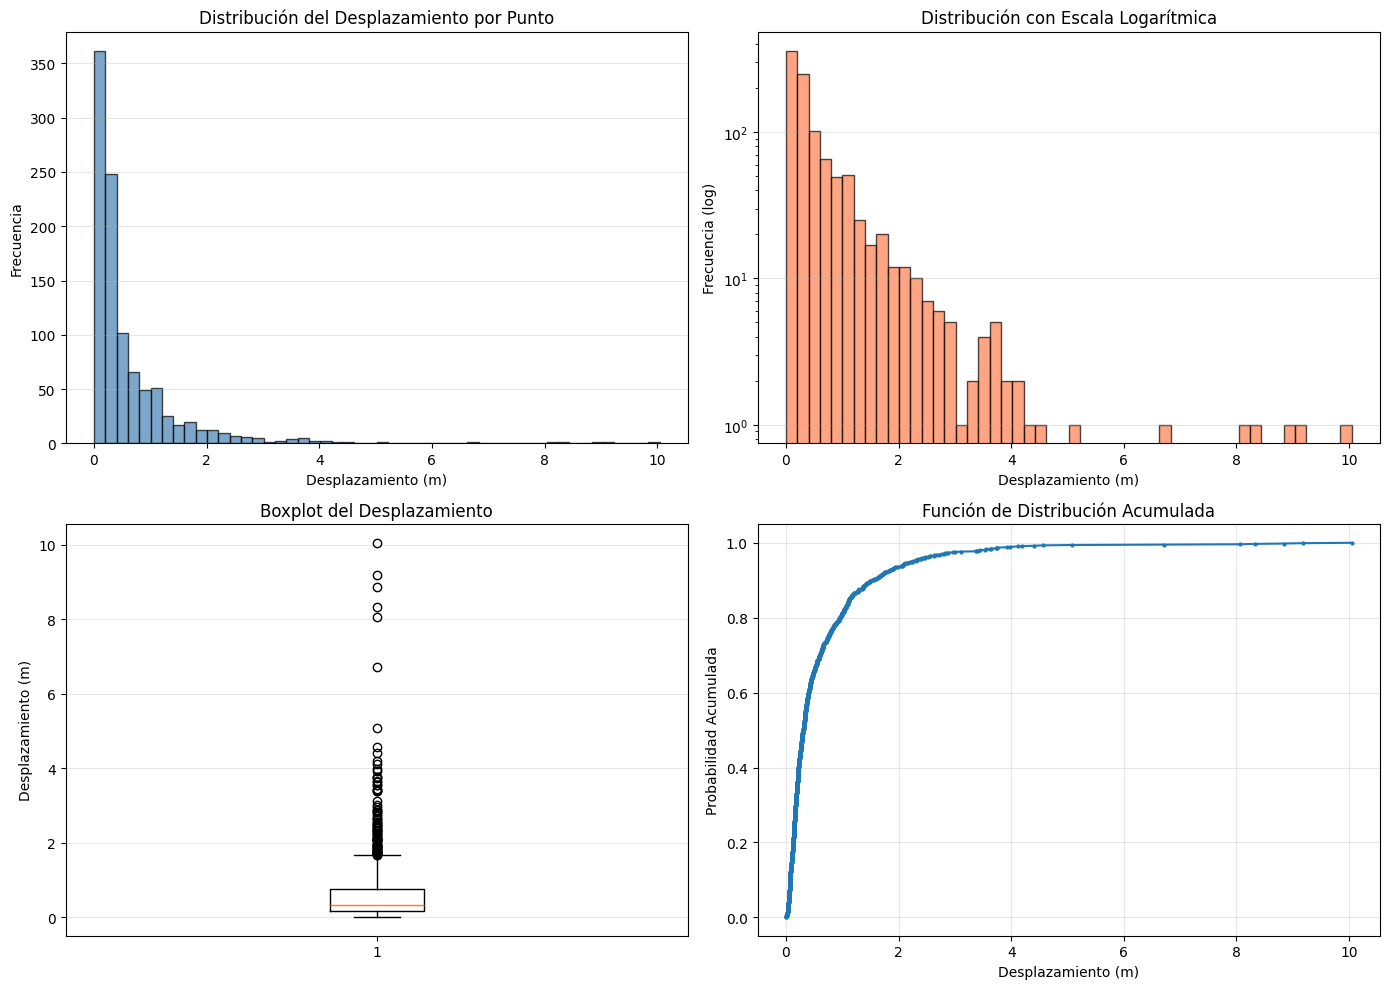


✓ Visualizaciones generadas


In [40]:
# Histograma de distribución del desplazamiento
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histograma simple
axes[0, 0].hist(df_distance_point["player_displacement_m"], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Desplazamiento (m)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución del Desplazamiento por Punto')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Histograma con escala logarítmica (para ver outliers)
axes[0, 1].hist(df_distance_point["player_displacement_m"], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Desplazamiento (m)')
axes[0, 1].set_ylabel('Frecuencia (log)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Distribución con Escala Logarítmica')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Boxplot
axes[1, 0].boxplot(df_distance_point["player_displacement_m"], vert=True)
axes[1, 0].set_ylabel('Desplazamiento (m)')
axes[1, 0].set_title('Boxplot del Desplazamiento')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Gráfico acumulativo
sorted_data = np.sort(df_distance_point["player_displacement_m"])
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1, 1].plot(sorted_data, cumulative, marker='o', linestyle='-', markersize=2)
axes[1, 1].set_xlabel('Desplazamiento (m)')
axes[1, 1].set_ylabel('Probabilidad Acumulada')
axes[1, 1].set_title('Función de Distribución Acumulada')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas")


### Revision de desplazamiento comparado con la medida de la cancha

Este bloque valida que los valores de desplazamiento del jugador sean razonables.  
Compara estadísticas del dataset (máximo, promedio y P95) con las dimensiones reales de una cancha de pádel para detectar valores imposibles o inconsistentes.  
Además, calcula la distribución de distancias recorridas por punto para evaluar si el tracking del movimiento tiene sentido físico.


In [41]:
# Análisis de sentido: validar si los valores son razonables
print("\n" + "=" * 60)
print("VALIDACIÓN: ¿Tiene sentido el cálculo?")
print("=" * 60)

# En una cancha de pádel:
# - Largo: ~20m, Ancho: ~10m
# - Diagonal: ~22.4m

desplazamiento_max = df_distance_point["player_displacement_m"].max()
desplazamiento_medio = df_distance_point["player_displacement_m"].mean()
desplazamiento_p95 = df_distance_point["player_displacement_m"].quantile(0.95)

print(f"\n📏 REFERENCIA DE CANCHA:")
print(f"   Largo cancha: ~20 m")
print(f"   Ancho cancha: ~10 m")
print(f"   Diagonal: ~22.4 m")

print(f"\n📊 TUS DATOS:")
print(f"   Desplazamiento máximo: {desplazamiento_max:.2f} m")
print(f"   Desplazamiento medio: {desplazamiento_medio:.2f} m")
print(f"   Desplazamiento P95: {desplazamiento_p95:.2f} m")

print(f"\n✅ VALIDACIÓN:")
if desplazamiento_max < 30:
    print(f"   ✓ El máximo ({desplazamiento_max:.2f}m) es razonable (cerca del diagonal de cancha)")
else:
    print(f"   ⚠ El máximo ({desplazamiento_max:.2f}m) parece muy alto")

if 1 < desplazamiento_medio < 5:
    print(f"   ✓ El promedio ({desplazamiento_medio:.2f}m) es coherente")
else:
    print(f"   ⚠ El promedio ({desplazamiento_medio:.2f}m) parece bajo o muy alto")

# Porcentajes
print(f"\n📈 DISTRIBUCIÓN:")
print(f"   {(df_distance_point['player_displacement_m'] < 5).sum() / len(df_distance_point) * 100:.1f}% de puntos: < 5m")
print(f"   {((df_distance_point['player_displacement_m'] >= 5) & (df_distance_point['player_displacement_m'] < 10)).sum() / len(df_distance_point) * 100:.1f}% de puntos: 5-10m")
print(f"   {(df_distance_point['player_displacement_m'] >= 10).sum() / len(df_distance_point) * 100:.1f}% de puntos: >= 10m")



VALIDACIÓN: ¿Tiene sentido el cálculo?

📏 REFERENCIA DE CANCHA:
   Largo cancha: ~20 m
   Ancho cancha: ~10 m
   Diagonal: ~22.4 m

📊 TUS DATOS:
   Desplazamiento máximo: 10.05 m
   Desplazamiento medio: 0.63 m
   Desplazamiento P95: 2.24 m

✅ VALIDACIÓN:
   ✓ El máximo (10.05m) es razonable (cerca del diagonal de cancha)
   ⚠ El promedio (0.63m) parece bajo o muy alto

📈 DISTRIBUCIÓN:
   99.3% de puntos: < 5m
   0.6% de puntos: 5-10m
   0.1% de puntos: >= 10m


### Relación entre la duración total del partido y la distancia recorrida por el jugador


Incluye una línea de tendencia para visualizar el patrón general y calcula la correlación de Pearson para cuantificar qué tan fuertemente se relacionan ambas variables.


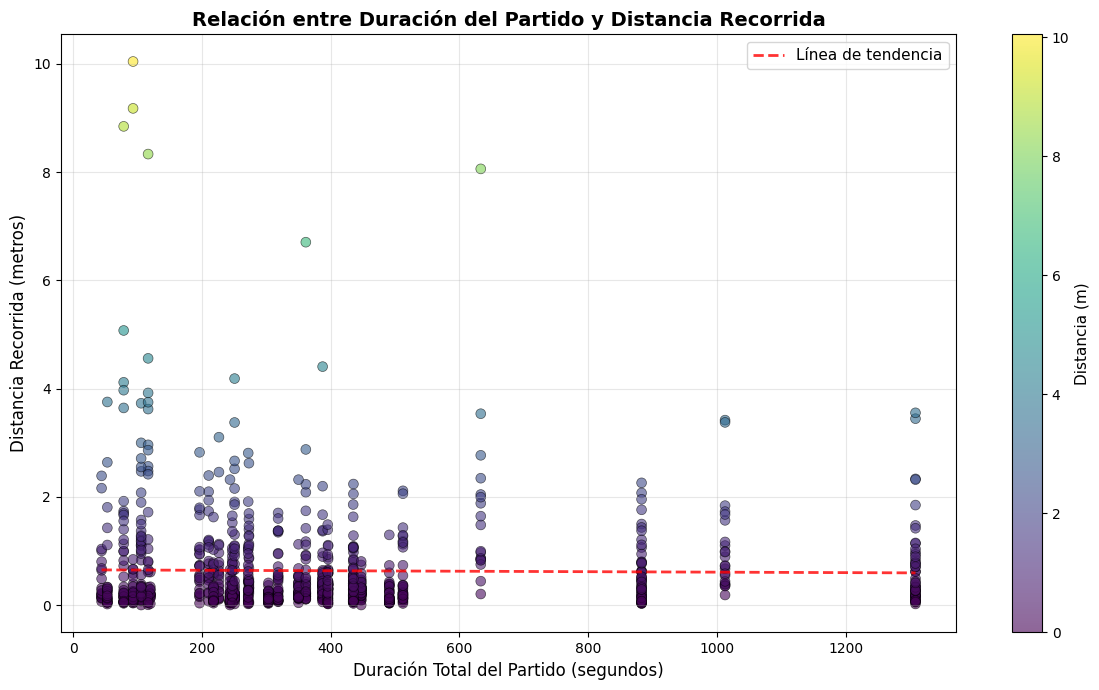


📊 CORRELACIÓN:
   Correlación (Pearson): -0.0134
   → Correlación débil


In [42]:
# Scatter plot: Distancia vs Duración del Partido
fig, ax = plt.subplots(figsize=(12, 7))

# Scatter plot
scatter = ax.scatter(
    df_distance_point["duracion_partido_total"], 
    df_distance_point["player_displacement_m"],
    alpha=0.6,
    s=50,
    c=df_distance_point["player_displacement_m"],
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Duración Total del Partido (segundos)', fontsize=12)
ax.set_ylabel('Distancia Recorrida (metros)', fontsize=12)
ax.set_title('Relación entre Duración del Partido y Distancia Recorrida', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Distancia (m)', fontsize=11)

# Agregar línea de tendencia
z = np.polyfit(df_distance_point["duracion_partido_total"].dropna(), 
               df_distance_point["player_displacement_m"].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(df_distance_point["duracion_partido_total"].min(), 
                      df_distance_point["duracion_partido_total"].max(), 100)
ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Línea de tendencia')

ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Estadísticas de correlación
correlation = df_distance_point["duracion_partido_total"].corr(df_distance_point["player_displacement_m"])
print(f"\n📊 CORRELACIÓN:")
print(f"   Correlación (Pearson): {correlation:.4f}")
print(f"   → {'Correlación positiva fuerte' if correlation > 0.7 else 'Correlación moderada' if correlation > 0.3 else 'Correlación débil'}")


###  Integración de datos de jugadores

Se eliminan las variables time_since_last_hit y player_displacement

In [43]:
df_point_avg = df_point_avg.drop(columns=["time_since_last_hit", "player_displacement"])

df_point_avg.head()

,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.076368,-3.999034e-15,4.567719,2.355334,1.427512,0.0,0.0,0,6.700000,40401,6.700000,Bueno,3-4 veces,1.145513,0.034365
1,ANDREA JULIETH SOSA RODRIGUEZ,17,2.0,0.960706,4.640279e-15,8.373752,2.775225,1.950169,0.0,0.0,2,9.866667,87616,9.866667,Bueno,3-4 veces,14.410597,0.432318
2,ANDREA JULIETH SOSA RODRIGUEZ,17,3.0,1.234223,-4.806613e-15,5.166349,3.075893,2.154784,0.0,0.0,0,11.400000,116964,11.400000,Bueno,3-4 veces,18.513341,0.555400
3,ANDREA JULIETH SOSA RODRIGUEZ,17,4.0,2.258672,5.002016e-15,6.707245,3.749423,3.741636,0.0,0.0,2,9.300000,78120,9.333333,Bueno,3-4 veces,33.880080,1.016402
4,ANDREA JULIETH SOSA RODRIGUEZ,17,5.0,0.338225,1.037143e-14,5.262476,2.955478,3.357214,0.0,0.0,0,9.566667,82369,9.566667,Bueno,3-4 veces,5.073368,0.152201


Se hace un *left join* para agregar información de cada jugador (edad, estatura, nivel, práctica de otro deporte) a `df_point_avg`, eliminando columnas duplicadas generadas por el merge.  
El resultado es un DataFrame limpio con toda la información relevante por jugador.

In [44]:
# Left join con df_jugadores para agregar variables adicionales
# Primero, crear un dataframe único por jugador de df_jugadores usando NOMBRE_clean
df_jugadores_unique = df_jugadores[["NOMBRE_clean", "EDAD", "PRACTICA_OTRO_DEPORTE_RAQUETA", "NIVEL_ACTUAL_PADEL", "ESTATURA"]].drop_duplicates()

# Hacer el left join usando player_name_clean como clave
df_point_avg = df_point_avg.merge(
    df_jugadores_unique,
    left_on="player_name_clean",
    right_on="NOMBRE_clean",
    how="left"
)

# Eliminar la columna NOMBRE_clean duplicada del merge
df_point_avg = df_point_avg.drop(columns=["NOMBRE_clean"], errors="ignore")

# Eliminar columnas con sufijo _x (duplicadas del merge)
cols_to_drop = [col for col in df_point_avg.columns if col.endswith('_x')]
df_point_avg = df_point_avg.drop(columns=cols_to_drop, errors="ignore")

# Eliminar columnas con sufijo _y y renombrar las sin sufijo
cols_to_drop_y = [col for col in df_point_avg.columns if col.endswith('_y')]
df_point_avg = df_point_avg.drop(columns=cols_to_drop_y, errors="ignore")

print("Columnas finales de df_point_avg:")
print(df_point_avg.columns.tolist())
print("\nPrimeras filas:")
df_point_avg.head()

Columnas finales de df_point_avg:
['player_name_clean', 'partido', 'punto', 'player_speed_mps', 'player_acceleration_mps2', 'distance_player_to_ball_m', 'distance_player_to_net_m', 'distance_player_to_teammate_m', 'ball_speed_mps', 'ball_displacement', 'player_hits_ball', 'duration', 'total_frames', 'video_duration', 'ESTADO_FISICO', 'FRECUENCIA_DEPORTE', 'player_displacement_px', 'player_displacement_m', 'EDAD', 'PRACTICA_OTRO_DEPORTE_RAQUETA', 'NIVEL_ACTUAL_PADEL', 'ESTATURA']

Primeras filas:


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
0,ANDREA JULIETH SOSA RODRIGUEZ,17,1.0,0.076368,-3.999034e-15,4.567719,2.355334,1.427512,0.0,0.0,0,6.700000,40401,6.700000,Bueno,3-4 veces,1.145513,0.034365,20.0,Tenis,Primera vez,162.0
1,ANDREA JULIETH SOSA RODRIGUEZ,17,2.0,0.960706,4.640279e-15,8.373752,2.775225,1.950169,0.0,0.0,2,9.866667,87616,9.866667,Bueno,3-4 veces,14.410597,0.432318,20.0,Tenis,Primera vez,162.0
2,ANDREA JULIETH SOSA RODRIGUEZ,17,3.0,1.234223,-4.806613e-15,5.166349,3.075893,2.154784,0.0,0.0,0,11.400000,116964,11.400000,Bueno,3-4 veces,18.513341,0.555400,20.0,Tenis,Primera vez,162.0
3,ANDREA JULIETH SOSA RODRIGUEZ,17,4.0,2.258672,5.002016e-15,6.707245,3.749423,3.741636,0.0,0.0,2,9.300000,78120,9.333333,Bueno,3-4 veces,33.880080,1.016402,20.0,Tenis,Primera vez,162.0
4,ANDREA JULIETH SOSA RODRIGUEZ,17,5.0,0.338225,1.037143e-14,5.262476,2.955478,3.357214,0.0,0.0,0,9.566667,82369,9.566667,Bueno,3-4 veces,5.073368,0.152201,20.0,Tenis,Primera vez,162.0


In [45]:
df_point_avg.shape

(1016, 22)

###  Imputación de valores faltantes

Se rellenan los datos faltantes de las variables de los jugadores:

- **Numéricas:**  
  - `EDAD` y `ESTATURA` se imputan con su promedio y se convierten a enteros.

- **Categóricas:**  
  - `PRACTICA_OTRO_DEPORTE_RAQUETA` y `NIVEL_ACTUAL_PADEL` se rellenan con `"Desconocido"` cuando faltan.


In [46]:
# --- Imputación EDAD y ESTATURA con su promedio ---

# EDAD → promedio y convertir a entero
df_point_avg['EDAD'] = df_point_avg['EDAD'].fillna(round(df_point_avg['EDAD'].mean())).astype(int)

# ESTATURA → promedio (en cm) y convertir a entero
df_point_avg['ESTATURA'] = df_point_avg['ESTATURA'].fillna(round(df_point_avg['ESTATURA'].mean())).astype(int)


# --- Imputación categórica con "Desconocido" ---

df_point_avg['PRACTICA_OTRO_DEPORTE_RAQUETA'] = df_point_avg['PRACTICA_OTRO_DEPORTE_RAQUETA'].fillna('Desconocido')

df_point_avg['NIVEL_ACTUAL_PADEL'] = df_point_avg['NIVEL_ACTUAL_PADEL'].fillna('Desconocido')


In [47]:
df_point_avg['EDAD'].describe()
df_point_avg['ESTATURA'].describe()


count    1016.000000
mean      171.724409
std         5.932696
min       160.000000
25%       170.000000
50%       172.000000
75%       173.500000
max       186.000000
Name: ESTATURA, dtype: float64

In [48]:
df_point_avg.shape

(1016, 22)

### Información general de `df_point_avg`

In [49]:
df_point_avg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   player_name_clean              1016 non-null   object 
 1   partido                        1016 non-null   object 
 2   punto                          1016 non-null   float64
 3   player_speed_mps               1016 non-null   float64
 4   player_acceleration_mps2       1016 non-null   float64
 5   distance_player_to_ball_m      1016 non-null   float64
 6   distance_player_to_net_m       1016 non-null   float64
 7   distance_player_to_teammate_m  1016 non-null   float64
 8   ball_speed_mps                 1016 non-null   float64
 9   ball_displacement              1016 non-null   float64
 10  player_hits_ball               1016 non-null   int64  
 11  duration                       1016 non-null   float64
 12  total_frames                   1016 non-null   i

### Detección de valores imposibles

Este bloque identifica registros con **valores fuera de rango físico esperado**:

1. **Velocidades del jugador** mayores a 7.5 m/s.
2. **Aceleraciones del jugador** mayores a 5 m/s².
3. **Velocidad de la pelota** mayor a 40 m/s.
4. **Distancias imposibles** (jugador a pelota, jugador a red, jugador a compañero) mayores a 12 m.

Sirve para detectar errores de tracking o datos mal medidos antes de análisis posteriores.

In [50]:
# 1. Velocidades imposibles (> 7.5 m/s)
df_point_avg[df_point_avg['player_speed_mps'] > 7.5]

# 2. Aceleraciones imposibles (> 5 m/s2)
df_point_avg[df_point_avg['player_acceleration_mps2'] > 5]

# 3. Velocidad de la pelota imposible (> 40 m/s)
df_point_avg[df_point_avg['ball_speed_mps'] > 40]

# 4. Distancias imposibles (> 12 metros)
cols_dist = ['distance_player_to_ball_m', 'distance_player_to_net_m', 'distance_player_to_teammate_m']
for col in cols_dist:
    print(col)
    display(df_point_avg[df_point_avg[col] > 12])


distance_player_to_ball_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
12,ANDREA JULIETH SOSA RODRIGUEZ,23,1.0,0.267956,0.000000e+00,12.662411,11.395344,4.747095,0.0,0.0,0,7.000000,44100,7.000000,Bueno,3-4 veces,4.019344,0.120580,20,Tenis,Primera vez,162
16,ANDREA JULIETH SOSA RODRIGUEZ,23,6.0,0.544032,-7.651999e-15,15.875875,8.880847,4.274005,0.0,0.0,2,7.000000,44100,7.000000,Bueno,3-4 veces,8.160486,0.244815,20,Tenis,Primera vez,162
17,ANDREA JULIETH SOSA RODRIGUEZ,23,7.0,0.725849,-3.085557e-01,15.917073,9.268663,4.747095,0.0,0.0,0,5.566667,27889,5.566667,Bueno,3-4 veces,10.887741,0.326632,20,Tenis,Primera vez,162
18,ANDREA JULIETH SOSA RODRIGUEZ,23,8.0,1.039140,1.851334e-01,14.334904,9.814200,4.747095,0.0,0.0,0,9.233333,76729,9.233333,Bueno,3-4 veces,15.587093,0.467613,20,Tenis,Primera vez,162
19,ANDREA JULIETH SOSA RODRIGUEZ,23,9.0,2.145915,4.547474e-14,12.520549,8.217088,3.827299,0.0,0.0,6,9.233333,76729,9.233333,Bueno,3-4 veces,32.188730,0.965662,20,Tenis,Primera vez,162
22,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,2.0,1.407612,9.156778e-02,12.992121,4.986300,6.572212,0.0,0.0,0,18.600000,343728,20.533333,Bueno,3-4 veces,21.114183,0.633425,20,Tenis,Primera vez,162
36,CARLOS FELIPE ANDRADE SAENZ,1,4.0,1.351810,-1.462980e-01,12.597146,8.197841,12.566301,0.0,0.0,0,11.666667,136150,12.966667,Desconocido,Desconocido,20.277148,0.608314,20,Desconocido,Desconocido,172
44,CARLOS FELIPE ANDRADE SAENZ,19,6.0,2.157769,1.989520e-14,16.115007,9.159970,8.057738,0.0,0.0,0,9.733333,85264,9.733333,Desconocido,Desconocido,32.366537,0.970996,20,Desconocido,Desconocido,172
45,CARLOS FELIPE ANDRADE SAENZ,19,7.0,1.857334,-2.397586e-14,12.306308,9.135421,8.057738,0.0,0.0,0,6.033333,32761,6.033333,Desconocido,Desconocido,27.860007,0.835800,20,Desconocido,Desconocido,172
135,DAVID SANTIAGO MURCIA BARRERA,31,1.0,0.650190,-3.280005e-14,12.102540,6.249825,3.383209,0.0,0.0,0,19.000000,326610,19.100000,Regular,3-4 veces,9.752854,0.292586,20,Tenis de mesa,Primera vez,173


distance_player_to_net_m


distance_player_to_ball_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
12,ANDREA JULIETH SOSA RODRIGUEZ,23,1.0,0.267956,0.000000e+00,12.662411,11.395344,4.747095,0.0,0.0,0,7.000000,44100,7.000000,Bueno,3-4 veces,4.019344,0.120580,20,Tenis,Primera vez,162
16,ANDREA JULIETH SOSA RODRIGUEZ,23,6.0,0.544032,-7.651999e-15,15.875875,8.880847,4.274005,0.0,0.0,2,7.000000,44100,7.000000,Bueno,3-4 veces,8.160486,0.244815,20,Tenis,Primera vez,162
17,ANDREA JULIETH SOSA RODRIGUEZ,23,7.0,0.725849,-3.085557e-01,15.917073,9.268663,4.747095,0.0,0.0,0,5.566667,27889,5.566667,Bueno,3-4 veces,10.887741,0.326632,20,Tenis,Primera vez,162
18,ANDREA JULIETH SOSA RODRIGUEZ,23,8.0,1.039140,1.851334e-01,14.334904,9.814200,4.747095,0.0,0.0,0,9.233333,76729,9.233333,Bueno,3-4 veces,15.587093,0.467613,20,Tenis,Primera vez,162
19,ANDREA JULIETH SOSA RODRIGUEZ,23,9.0,2.145915,4.547474e-14,12.520549,8.217088,3.827299,0.0,0.0,6,9.233333,76729,9.233333,Bueno,3-4 veces,32.188730,0.965662,20,Tenis,Primera vez,162
22,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,2.0,1.407612,9.156778e-02,12.992121,4.986300,6.572212,0.0,0.0,0,18.600000,343728,20.533333,Bueno,3-4 veces,21.114183,0.633425,20,Tenis,Primera vez,162
36,CARLOS FELIPE ANDRADE SAENZ,1,4.0,1.351810,-1.462980e-01,12.597146,8.197841,12.566301,0.0,0.0,0,11.666667,136150,12.966667,Desconocido,Desconocido,20.277148,0.608314,20,Desconocido,Desconocido,172
44,CARLOS FELIPE ANDRADE SAENZ,19,6.0,2.157769,1.989520e-14,16.115007,9.159970,8.057738,0.0,0.0,0,9.733333,85264,9.733333,Desconocido,Desconocido,32.366537,0.970996,20,Desconocido,Desconocido,172
45,CARLOS FELIPE ANDRADE SAENZ,19,7.0,1.857334,-2.397586e-14,12.306308,9.135421,8.057738,0.0,0.0,0,6.033333,32761,6.033333,Desconocido,Desconocido,27.860007,0.835800,20,Desconocido,Desconocido,172
135,DAVID SANTIAGO MURCIA BARRERA,31,1.0,0.650190,-3.280005e-14,12.102540,6.249825,3.383209,0.0,0.0,0,19.000000,326610,19.100000,Regular,3-4 veces,9.752854,0.292586,20,Tenis de mesa,Primera vez,173


distance_player_to_net_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
183,ISABELLA BUITRAGO HURTADO,31,8.0,0.072601,0.000000e+00,17.941502,12.533097,2.704385,0.0,0.0,0,6.266667,35344,6.266667,Regular,1-2 veces,1.089020,0.032671,18,Tenis,Primera vez,162
334,JUAN PABLO BENITEZ BERNAL,13,1.0,3.532036,3.225159e-14,14.446736,12.531612,4.859340,0.0,0.0,0,9.466667,80656,9.466667,Excelente,Más de 4 veces,52.980538,1.589416,21,Tenis,Primera vez,175


distance_player_to_ball_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
12,ANDREA JULIETH SOSA RODRIGUEZ,23,1.0,0.267956,0.000000e+00,12.662411,11.395344,4.747095,0.0,0.0,0,7.000000,44100,7.000000,Bueno,3-4 veces,4.019344,0.120580,20,Tenis,Primera vez,162
16,ANDREA JULIETH SOSA RODRIGUEZ,23,6.0,0.544032,-7.651999e-15,15.875875,8.880847,4.274005,0.0,0.0,2,7.000000,44100,7.000000,Bueno,3-4 veces,8.160486,0.244815,20,Tenis,Primera vez,162
17,ANDREA JULIETH SOSA RODRIGUEZ,23,7.0,0.725849,-3.085557e-01,15.917073,9.268663,4.747095,0.0,0.0,0,5.566667,27889,5.566667,Bueno,3-4 veces,10.887741,0.326632,20,Tenis,Primera vez,162
18,ANDREA JULIETH SOSA RODRIGUEZ,23,8.0,1.039140,1.851334e-01,14.334904,9.814200,4.747095,0.0,0.0,0,9.233333,76729,9.233333,Bueno,3-4 veces,15.587093,0.467613,20,Tenis,Primera vez,162
19,ANDREA JULIETH SOSA RODRIGUEZ,23,9.0,2.145915,4.547474e-14,12.520549,8.217088,3.827299,0.0,0.0,6,9.233333,76729,9.233333,Bueno,3-4 veces,32.188730,0.965662,20,Tenis,Primera vez,162
22,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,2.0,1.407612,9.156778e-02,12.992121,4.986300,6.572212,0.0,0.0,0,18.600000,343728,20.533333,Bueno,3-4 veces,21.114183,0.633425,20,Tenis,Primera vez,162
36,CARLOS FELIPE ANDRADE SAENZ,1,4.0,1.351810,-1.462980e-01,12.597146,8.197841,12.566301,0.0,0.0,0,11.666667,136150,12.966667,Desconocido,Desconocido,20.277148,0.608314,20,Desconocido,Desconocido,172
44,CARLOS FELIPE ANDRADE SAENZ,19,6.0,2.157769,1.989520e-14,16.115007,9.159970,8.057738,0.0,0.0,0,9.733333,85264,9.733333,Desconocido,Desconocido,32.366537,0.970996,20,Desconocido,Desconocido,172
45,CARLOS FELIPE ANDRADE SAENZ,19,7.0,1.857334,-2.397586e-14,12.306308,9.135421,8.057738,0.0,0.0,0,6.033333,32761,6.033333,Desconocido,Desconocido,27.860007,0.835800,20,Desconocido,Desconocido,172
135,DAVID SANTIAGO MURCIA BARRERA,31,1.0,0.650190,-3.280005e-14,12.102540,6.249825,3.383209,0.0,0.0,0,19.000000,326610,19.100000,Regular,3-4 veces,9.752854,0.292586,20,Tenis de mesa,Primera vez,173


distance_player_to_net_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
183,ISABELLA BUITRAGO HURTADO,31,8.0,0.072601,0.000000e+00,17.941502,12.533097,2.704385,0.0,0.0,0,6.266667,35344,6.266667,Regular,1-2 veces,1.089020,0.032671,18,Tenis,Primera vez,162
334,JUAN PABLO BENITEZ BERNAL,13,1.0,3.532036,3.225159e-14,14.446736,12.531612,4.859340,0.0,0.0,0,9.466667,80656,9.466667,Excelente,Más de 4 veces,52.980538,1.589416,21,Tenis,Primera vez,175


distance_player_to_teammate_m


,player_name_clean,partido,punto,player_speed_mps,player_acceleration_mps2,distance_player_to_ball_m,distance_player_to_net_m,distance_player_to_teammate_m,ball_speed_mps,ball_displacement,player_hits_ball,duration,total_frames,video_duration,ESTADO_FISICO,FRECUENCIA_DEPORTE,player_displacement_px,player_displacement_m,EDAD,PRACTICA_OTRO_DEPORTE_RAQUETA,NIVEL_ACTUAL_PADEL,ESTATURA
33,CARLOS FELIPE ANDRADE SAENZ,1,1.0,0.383206,2.296704e-15,7.869224,7.854058,12.963738,0.0,0.0,5,16.566667,330008,22.133333,Desconocido,Desconocido,5.748094,0.172443,20,Desconocido,Desconocido,172
34,CARLOS FELIPE ANDRADE SAENZ,1,2.0,0.614451,8.931875e-01,8.384461,8.842185,15.324313,0.0,0.0,0,1.966667,7316,4.133333,Desconocido,Desconocido,9.216771,0.276503,20,Desconocido,Desconocido,172
35,CARLOS FELIPE ANDRADE SAENZ,1,3.0,0.437386,-4.675592e-15,9.550173,8.891396,12.961930,0.0,0.0,5,6.500000,44655,7.633333,Desconocido,Desconocido,6.560785,0.196824,20,Desconocido,Desconocido,172
36,CARLOS FELIPE ANDRADE SAENZ,1,4.0,1.351810,-1.462980e-01,12.597146,8.197841,12.566301,0.0,0.0,0,11.666667,136150,12.966667,Desconocido,Desconocido,20.277148,0.608314,20,Desconocido,Desconocido,172
37,CARLOS FELIPE ANDRADE SAENZ,1,6.0,0.304600,3.667317e-15,9.166186,9.029016,13.400043,0.0,0.0,0,5.233333,30615,6.500000,Desconocido,Desconocido,4.568998,0.137070,20,Desconocido,Desconocido,172
38,CARLOS FELIPE ANDRADE SAENZ,1,7.0,0.441431,3.346161e-15,2.349374,8.193103,12.938479,0.0,0.0,3,5.800000,42108,8.066667,Desconocido,Desconocido,6.621462,0.198644,20,Desconocido,Desconocido,172
39,CARLOS FELIPE ANDRADE SAENZ,1,8.0,0.480833,-4.278293e-01,6.839041,8.679155,12.964319,0.0,0.0,6,4.033333,23958,6.600000,Desconocido,Desconocido,7.212489,0.216375,20,Desconocido,Desconocido,172
159,FERMIN ALEJANDRO ESCALONA GUILLEN,6,5.0,0.607901,1.531179e+00,3.518446,6.006914,12.526237,0.0,0.0,2,2.250000,18225,2.250000,Excelente,Más de 4 veces,4.559256,0.136778,19,No,Primera vez,176
349,JUAN PABLO BENITEZ BERNAL,31,4.0,0.417153,0.000000e+00,0.830840,6.100494,12.865789,0.0,0.0,2,6.000000,32400,6.000000,Excelente,Más de 4 veces,6.257302,0.187719,21,Tenis,Primera vez,175
785,SANTIAGO NAVARRO CUY,1,2.0,0.055189,0.000000e+00,5.388320,5.192473,21.126339,0.0,0.0,0,4.133333,15376,4.133333,Malo,0 veces,0.827832,0.024835,19,No,Primera vez,180


###  Corrección de distancias imposibles

Para las columnas de distancia (`distance_player_to_ball_m`, `distance_player_to_net_m`, `distance_player_to_teammate_m`):

- Se calcula la **media de los valores válidos** (≤ 12 m).  
- Se reemplazan valores **mayores a 12 m** o **negativos** con esta media.  

Esto asegura que todas las distancias estén dentro de un rango físicamente razonable.

In [51]:
cols_dist = [
    'distance_player_to_ball_m',
    'distance_player_to_net_m',
    'distance_player_to_teammate_m'
]

for col in cols_dist:
    # media solo con valores válidos (≤ 12 metros)
    valid_mean = df_point_avg.loc[df_point_avg[col] <= 12, col].mean()

    # imputamos valores imposibles (> 12) con la media válida
    df_point_avg.loc[df_point_avg[col] > 12, col] = valid_mean

    # también corregimos cualquier valor negativo por si acaso
    df_point_avg.loc[df_point_avg[col] < 0, col] = valid_mean


- **Velocidad del jugador:** valores > 7.5 m/s se reemplazan por la media de los válidos.  
- **Aceleración del jugador:** valores > 5 m/s² se reemplazan por la media de los válidos.  
- **Velocidad de la pelota:** valores > 40 m/s se reemplazan por la media de los válidos.  

In [52]:
# velocidad del jugador
valid_speed_mean = df_point_avg.loc[df_point_avg['player_speed_mps'] <= 7.5, 'player_speed_mps'].mean()
df_point_avg.loc[df_point_avg['player_speed_mps'] > 7.5, 'player_speed_mps'] = valid_speed_mean

# aceleración
valid_acc_mean = df_point_avg.loc[df_point_avg['player_acceleration_mps2'] <= 5, 'player_acceleration_mps2'].mean()
df_point_avg.loc[df_point_avg['player_acceleration_mps2'] > 5, 'player_acceleration_mps2'] = valid_acc_mean

# velocidad de la bola
valid_ball_speed_mean = df_point_avg.loc[df_point_avg['ball_speed_mps'] <= 40, 'ball_speed_mps'].mean()
df_point_avg.loc[df_point_avg['ball_speed_mps'] > 40, 'ball_speed_mps'] = valid_ball_speed_mean


Se filtran aceleraciones **realistas** entre -5 y +5 m/s² y se calcula su media.  
Los valores fuera de este rango se reemplazan con la media, asegurando que todas las aceleraciones sean físicamente plausibles.

In [53]:
# Filtra solo aceleraciones realistas entre -5 y +5 m/s2
valid_acc = df_point_avg.loc[(df_point_avg['player_acceleration_mps2'] >= -5) &
                             (df_point_avg['player_acceleration_mps2'] <= 5),
                             'player_acceleration_mps2']

valid_acc_mean = valid_acc.mean()

# Reemplaza valores irreales fuera del rango
df_point_avg.loc[df_point_avg['player_acceleration_mps2'] < -5, 'player_acceleration_mps2'] = valid_acc_mean
df_point_avg.loc[df_point_avg['player_acceleration_mps2'] > 5,  'player_acceleration_mps2'] = valid_acc_mean


In [54]:
df_point_avg.drop(columns=['ball_speed_mps'], inplace=True)


In [55]:
df_point_avg['player_acceleration_mps2'].describe()


count    1.016000e+03
mean     2.348550e-02
std      5.749028e-01
min     -4.907151e+00
25%     -1.122318e-14
50%      0.000000e+00
75%      7.358525e-14
max      4.735971e+00
Name: player_acceleration_mps2, dtype: float64

###  Histograma de aceleraciones del jugador

Se genera un histograma de la columna `player_acceleration_mps2` con 50 bins para visualizar:

- La **distribución de aceleraciones** entre los jugadores.  
- Valores extremos o outliers después de la corrección.  
- Tendencias generales de aceleración durante los puntos de los partidos.

<Axes: >

<Axes: >

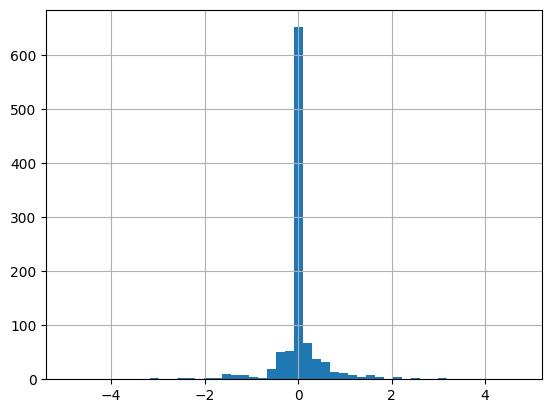

In [56]:
df_point_avg['player_acceleration_mps2'].hist(bins=50)


##  Resumen por jugador y partido

Se agregan métricas de cada jugador **por partido** para obtener estadísticas resumidas:

- **Velocidad y aceleración:** media, desviación estándar, máximos y mínimos.  
- **Distancias (bola, red, compañero):** media y desviación estándar.  
- **Actividad y desplazamiento:** sumas y medias según corresponda.  
- **Duración y frames:** sumas totales y promedios.  
- **Información personal y categórica:** se mantiene la primera observación por jugador (edad, estatura, nivel, estado físico, etc.).  


In [57]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier


In [58]:
# Asegúrate de que partido esté como string (opcional, solo por consistencia)
df_point_avg['partido'] = df_point_avg['partido'].astype(str)

agg_dict = {
    'player_speed_mps': ['mean', 'std', 'max'],
    'player_acceleration_mps2': ['mean', 'std', 'max', 'min'],
    'distance_player_to_ball_m': ['mean', 'std'],
    'distance_player_to_net_m': ['mean', 'std'],
    'distance_player_to_teammate_m': ['mean', 'std'],
    'ball_displacement': ['sum'],
    'player_hits_ball': ['sum'],
    'duration': ['sum', 'mean'],
    'total_frames': ['sum'],
    'video_duration': ['first'],
    'player_displacement_m': ['sum', 'mean'],
    'EDAD': ['first'],
    'ESTATURA': ['first'],
    'PRACTICA_OTRO_DEPORTE_RAQUETA': ['first'],
    'NIVEL_ACTUAL_PADEL': ['first'],
    'ESTADO_FISICO': ['first'],
    'FRECUENCIA_DEPORTE': ['first']
}

matches = df_point_avg.groupby(
    ['player_name_clean', 'partido']
).agg(agg_dict).reset_index()

# Aplanar columnas MultiIndex tipo (col, agg) → col_agg
matches.columns = [
    '_'.join([str(c) for c in col if c != '']).strip('_')
    for col in matches.columns
]

matches.head()


,player_name_clean,partido,player_speed_mps_mean,player_speed_mps_std,player_speed_mps_max,player_acceleration_mps2_mean,player_acceleration_mps2_std,player_acceleration_mps2_max,player_acceleration_mps2_min,distance_player_to_ball_m_mean,distance_player_to_ball_m_std,distance_player_to_net_m_mean,distance_player_to_net_m_std,distance_player_to_teammate_m_mean,distance_player_to_teammate_m_std,ball_displacement_sum,player_hits_ball_sum,duration_sum,duration_mean,total_frames_sum,video_duration_first,player_displacement_m_sum,player_displacement_m_mean,EDAD_first,ESTATURA_first,PRACTICA_OTRO_DEPORTE_RAQUETA_first,NIVEL_ACTUAL_PADEL_first,ESTADO_FISICO_first,FRECUENCIA_DEPORTE_first
0,ANDREA JULIETH SOSA RODRIGUEZ,17,0.994176,0.740275,2.280419,-0.030523,0.105733,1.037143e-14,-0.366271,5.860039,1.736788,2.901612,0.494912,3.241905,1.001009,0.0,12,98.133333,8.177778,757707,6.700000,5.368553,0.447379,20,162,Tenis,Primera vez,Bueno,3-4 veces
1,ANDREA JULIETH SOSA RODRIGUEZ,23,1.282758,0.734321,2.503158,-0.010876,0.153363,1.851334e-01,-0.308556,7.686406,2.221061,8.449625,1.658551,4.795484,0.702167,0.0,16,75.466667,8.385185,595450,7.000000,5.195168,0.577241,20,162,Tenis,Primera vez,Bueno,3-4 veces
2,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,1.776705,1.270778,4.605290,0.157706,0.369875,9.737208e-01,-0.294287,7.284096,1.967448,3.308851,1.085917,6.215994,0.849179,0.0,0,148.400000,12.366667,2113794,8.166667,9.594208,0.799517,20,162,Tenis,Primera vez,Bueno,3-4 veces
3,CARLOS FELIPE ANDRADE SAENZ,1,0.573388,0.356024,1.351810,0.045580,0.405726,8.931875e-01,-0.427829,7.200342,2.443118,8.526679,0.443467,5.296399,0.000000,0.0,19,51.766667,7.395238,614810,22.133333,1.806172,0.258025,20,172,Desconocido,Desconocido,Desconocido,Desconocido
4,CARLOS FELIPE ANDRADE SAENZ,19,2.737854,1.750381,6.150522,-0.018910,0.203126,3.886388e-01,-0.318198,9.140136,2.537018,8.124200,1.803689,8.057738,0.000000,0.0,5,105.533333,11.725926,1248068,13.933333,21.380848,2.375650,20,172,Desconocido,Desconocido,Desconocido,Desconocido


In [59]:
matches.shape

(104, 29)

###  Preparación de datos para modelado

- Se filtra el dataset de partidos para conservar solo jugadores con **estado físico conocido** (`ESTADO_FISICO_first` ≠ "Desconocido").  
- Se define el **target** como `ESTADO_FISICO_first`.  
- Se seleccionan las **features** excluyendo columnas irrelevantes (`player_name_clean`, `partido`, `ESTADO_FISICO_first`, `FRECUENCIA_DEPORTE_first`).  
- Se separan las features en **numéricas** y **categóricas** para facilitar su uso en análisis y modelos de predicción.

In [60]:
# Copiar dataset de partidos
df_estado = matches[matches['ESTADO_FISICO_first'] != 'Desconocido'].copy()

# Definir target
target_estado = 'ESTADO_FISICO_first'

# Features: todo excepto estos
drop_cols = ['player_name_clean', 'partido', 'ESTADO_FISICO_first', 'FRECUENCIA_DEPORTE_first']

feature_cols = [c for c in matches.columns if c not in drop_cols]

# Separar numéricas y categóricas
num_features = [c for c in feature_cols if df_estado[c].dtype != 'object']
cat_features = [c for c in feature_cols if df_estado[c].dtype == 'object']

X = df_estado[feature_cols]
y = df_estado[target_estado]


###  Codificación del target `ESTADO_FISICO`

- Se utiliza `LabelEncoder` para convertir las categorías de `ESTADO_FISICO` en valores numéricos.  
- Cada clase recibe un código único, facilitando el uso en algoritmos de machine learning que requieren variables numéricas.


In [61]:
le_estado = LabelEncoder()
y_encoded = le_estado.fit_transform(y)

print("Clases originales → codificación:")
for clase, code in zip(le_estado.classes_, range(len(le_estado.classes_))):
    print(clase, "→", code)


Clases originales → codificación:
Bueno → 0
Excelente → 1
Malo → 2
Regular → 3


### 🛠️ Preparación y Pipeline para clasificación 

- **Split de datos**: Se divide el dataset en entrenamiento (80%) y prueba (20%), usando `stratify` para mantener la proporción de clases en ambos conjuntos.  
- **Preprocesamiento numérico**: Imputación de valores faltantes con la mediana y escalado estándar.  
- **Preprocesamiento categórico**: Imputación con la moda y codificación one-hot ignorando categorías desconocidas.  
- **ColumnTransformer**: Combina los pasos de preprocesamiento para columnas numéricas y categóricas.  
- **Modelo**: `XGBClassifier` con configuración para clasificación múltiple (`multi:softprob`) y parámetros ajustados (profundidad, learning rate, subsample, colsample).  
- **Pipeline final**: Encapsula el preprocesamiento y el modelo, permitiendo entrenar y predecir de forma ordenada.

In [62]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [63]:
# Preprocesamiento para numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocesamiento para categóricas
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# Modelo XGBoost
xgb_estado = XGBClassifier(
    objective='multi:softprob',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

# Pipeline final
pipe_estado = Pipeline(steps=[
    ("preprocess", preprocessor),       
    ("model", xgb_estado)
])


###  Entrenamiento del modelo XGBoost

In [64]:
pipe_estado.fit(X_train_e, y_train_e)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
# Predicción (codificada)
y_pred_e = pipe_estado.predict(X_test_e)

# Convertir al nombre real (Malo, Regular, Bueno, Excelente)
y_pred_labels = le_estado.inverse_transform(y_pred_e)
y_test_labels = le_estado.inverse_transform(y_test_e)


In [66]:
print("=== ESTADO_FISICO ===")
print(classification_report(y_test_labels, y_pred_labels))
print(confusion_matrix(y_test_labels, y_pred_labels))


=== ESTADO_FISICO ===
              precision    recall  f1-score   support

       Bueno       0.64      1.00      0.78         9
   Excelente       0.00      0.00      0.00         2
        Malo       0.00      0.00      0.00         1
     Regular       1.00      0.67      0.80         6

    accuracy                           0.72        18
   macro avg       0.41      0.42      0.40        18
weighted avg       0.65      0.72      0.66        18

[[9 0 0 0]
 [2 0 0 0]
 [1 0 0 0]
 [2 0 0 4]]


=== ESTADO_FISICO ===
              precision    recall  f1-score   support

       Bueno       0.64      1.00      0.78         9
   Excelente       0.00      0.00      0.00         2
        Malo       0.00      0.00      0.00         1
     Regular       1.00      0.67      0.80         6

    accuracy                           0.72        18
   macro avg       0.41      0.42      0.40        18
weighted avg       0.65      0.72      0.66        18

[[9 0 0 0]
 [2 0 0 0]
 [1 0 0 0]
 [2 0 0 4]]


c:\Users\limao\Desktop\U SABANA\SEXTO SEMESTRE\ANALITICA DE DATOS\ProyectoAnalitica\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\limao\Desktop\U SABANA\SEXTO SEMESTRE\ANALITICA DE DATOS\ProyectoAnalitica\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\limao\Desktop\U SABANA\SEXTO SEMESTRE\ANALITICA DE DATOS\ProyectoAnalitica\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 


- **Accuracy**: el modelo acierta el 72% de las predicciones totales.  
- **Matriz de confusión**: indica que casi todas las predicciones caen en `Bueno` y `Regular`, mientras que `Excelente` y `Malo` no se detectan correctamente.

### 🔹 Análisis PCA sobre variables físicas

- Se seleccionaron **solo variables físicas numéricas** (`player_name_clean`, `partido`, `ESTADO_FISICO_first` y `FRECUENCIA_DEPORTE_first` se excluyeron).  
- Los datos se **escalaron** para tener media 0 y desviación 1.  
- Se aplicó **PCA** con 2 componentes principales para reducir la dimensionalidad.  
- Se muestra la **varianza explicada** por PC1 y PC2, indicando cuánto de la información original capturan estas dos dimensiones.



In [67]:
df_plot = matches.dropna(subset=['ESTADO_FISICO_first']).copy()

print("Partidos totales en matches:", matches.shape[0])
print("Partidos SIN estado físico (eliminados):", matches['ESTADO_FISICO_first'].isna().sum())
print("Partidos con estado físico (usados en PCA):", df_plot.shape[0])


Partidos totales en matches: 104
Partidos SIN estado físico (eliminados): 0
Partidos con estado físico (usados en PCA): 104


In [68]:
variables_fisicas = [
    c for c in df_plot.columns
    if c not in [
        'player_name_clean', 'partido',
        'ESTADO_FISICO_first', 'FRECUENCIA_DEPORTE_first'
    ] and df_plot[c].dtype != 'object'
]

X_unsup = df_plot[variables_fisicas].copy()


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)


In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por PC1 y PC2:", pca.explained_variance_ratio_)


Varianza explicada por PC1 y PC2: [0.23792421 0.15349308]


### 🔹 Loadings de PCA

- Los **loadings** muestran la contribución de cada variable física a las **dos componentes principales (PC1 y PC2)**.  
- Cada fila representa una variable original y cada columna una componente principal.  
- Valores más altos (positivos o negativos) indican que la variable **tiene mayor peso** en esa componente y, por lo tanto, influye más en la dirección del eje principal del PCA.


In [71]:
# Obtener nombres de variables
feature_names = variables_fisicas  # <-- las variables numéricas que usaste en PCA

# Loadings → matriz (n_variables × n_componentes)
loadings = pd.DataFrame(
    pca.components_.T,   # transpuesta para tener variables en filas
    columns=["PC1", "PC2"],
    index=feature_names
)

print(loadings)


                                             PC1       PC2
player_speed_mps_mean               3.384459e-01  0.200596
player_speed_mps_std                3.389760e-01  0.158990
player_speed_mps_max                3.370056e-01  0.189163
player_acceleration_mps2_mean      -1.144637e-01 -0.042960
player_acceleration_mps2_std        2.838983e-01 -0.132266
player_acceleration_mps2_max        1.641059e-01 -0.145533
player_acceleration_mps2_min       -2.907945e-01  0.071600
distance_player_to_ball_m_mean      7.529232e-02  0.181375
distance_player_to_ball_m_std       8.833557e-02  0.081609
distance_player_to_net_m_mean       5.237546e-02 -0.027425
distance_player_to_net_m_std        2.106667e-01  0.071927
distance_player_to_teammate_m_mean -1.017622e-01  0.206004
distance_player_to_teammate_m_std   5.314946e-02  0.039370
ball_displacement_sum               3.231174e-27  0.000000
player_hits_ball_sum               -1.390722e-01  0.172011
duration_sum                       -1.569670e-01  0.4693

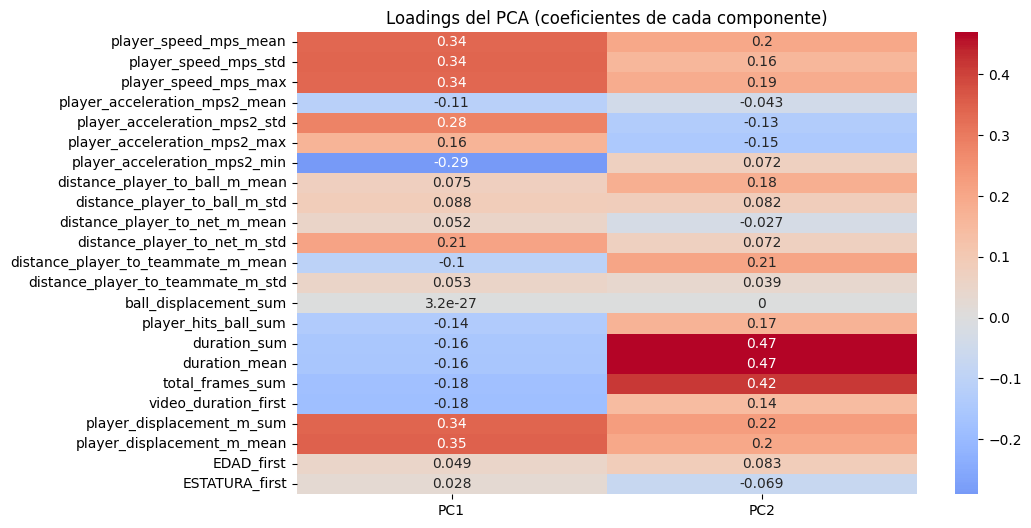

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Loadings del PCA (coeficientes de cada componente)")
plt.show()


### 🔹 Clustering con KMeans

- Se aplicó **KMeans** con 3 clusters sobre las variables físicas estandarizadas.  
- Cada punto representa un partido/jugador proyectado en las dos componentes principales del PCA (PC1 y PC2).  
- Los colores indican el **cluster asignado por el algoritmo**, mostrando cómo los partidos se agrupan según similitudes en sus métricas físicas, sin usar la variable `ESTADO_FISICO_first`.  
- Este análisis permite identificar patrones de desempeño físico de manera **no supervisada**.


In [73]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_plot['cluster'] = clusters


In [74]:
colores = {
    'Malo': 'red',
    'Regular': 'orange',
    'Bueno': 'blue',
    'Excelente': 'green'
}

estado_color = df_plot['ESTADO_FISICO_first'].map(colores)


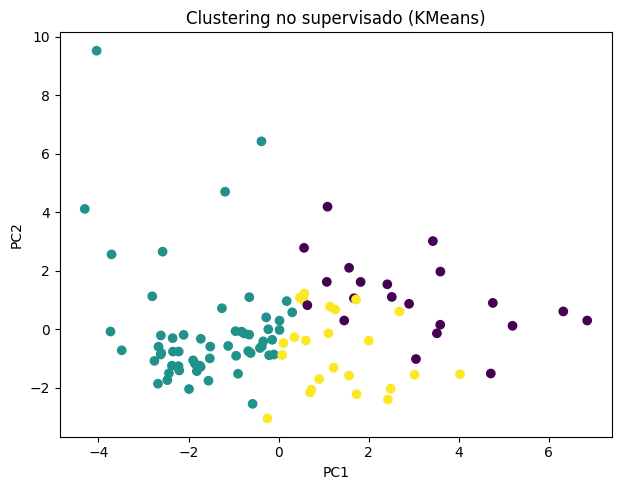

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# --- Gráfico 1: Clusters ---
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_plot['cluster'], cmap='viridis')
plt.title("Clustering no supervisado (KMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")


plt.tight_layout()
plt.show()


### 🔹 Comparación entre clusters y `ESTADO_FISICO_first`

- Se creó una **tabla cruzada** (`crosstab`) entre los clusters generados por KMeans y la variable `ESTADO_FISICO_first`.  
- Luego se identificaron casos donde existe **sobreestimación** o **subestimación** del estado físico declarado en relación con el cluster de desempeño físico:
  - **Sobreestimación:** el jugador declara un estado físico alto (`Bueno` o `Excelente`) pero su cluster indica rendimiento medio o bajo.  
  - **Subestimación:** el jugador declara un estado físico bajo (`Malo` o `Regular`) pero su cluster indica rendimiento alto.  
- `mintiendo_df` contiene los índices, el estado físico declarado, el cluster asignado y el motivo de la discrepancia, permitiendo detectar inconsistencias entre percepción y desempeño real.


In [76]:
tabla = pd.crosstab(df_plot['cluster'], df_plot['ESTADO_FISICO_first'])
print(tabla)


ESTADO_FISICO_first  Bueno  Desconocido  Excelente  Malo  Regular
cluster                                                          
0                        9            4          2     1        5
1                       23           10          7     3       16
2                       13            0          1     0       10


In [77]:
df_plot['cluster']


0      1
1      1
2      2
3      1
4      0
      ..
99     0
100    0
101    0
102    1
103    2
Name: cluster, Length: 104, dtype: int32

In [78]:
# --- PREP ---
df_plot = df_plot.dropna(subset=['ESTADO_FISICO_first']).copy()

# Añadir PC1 y PC2 al dataframe si no existen
df_plot['PC1'] = X_pca[:, 0]
df_plot['PC2'] = X_pca[:, 1]

# Añadir cluster si no existe
df_plot['cluster'] = clusters

mintiendo = []

# --- LOOP ---
for idx, row in df_plot.iterrows():
    est = row['ESTADO_FISICO_first']
    cl = row['cluster']
    pc1 = row['PC1']
    
    # === SOBREESTIMACIÓN ===
    if cl == 2 and est in ['Bueno', 'Excelente']:
        mintiendo.append((idx, est, cl, pc1, "Sobreestima: bajo rendimiento pero declara buen estado"))
    
    if cl == 0 and est == 'Excelente':
        mintiendo.append((idx, est, cl, pc1, "Sobreestima: rendimiento medio pero declara excelente"))
    
    # === SUBESTIMACIÓN ===
    if cl == 1 and est == 'Malo':
        mintiendo.append((idx, est, cl, pc1, "Subestima: alto rendimiento pero declara estado malo"))
    
    if cl == 1 and est == 'Regular':
        mintiendo.append((idx, est, cl, pc1, "Subestima: alto rendimiento pero declara regular"))
    
    if cl == 0 and est == 'Malo':
        mintiendo.append((idx, est, cl, pc1, "Subestima: rendimiento medio pero declara estado malo"))

mintiendo_df = pd.DataFrame(mintiendo, columns=['index','estado_fisico','cluster','PC1','motivo'])
mintiendo_df


,index,estado_fisico,cluster,PC1,motivo
0,2,Bueno,2,0.551995,Sobreestima: bajo rendimiento pero declara bue...
1,7,Bueno,2,1.720576,Sobreestima: bajo rendimiento pero declara bue...
2,11,Bueno,2,3.019912,Sobreestima: bajo rendimiento pero declara bue...
3,14,Regular,1,-1.119219,Subestima: alto rendimiento pero declara regular
4,16,Regular,1,-0.764461,Subestima: alto rendimiento pero declara regular
5,17,Excelente,2,1.224401,Sobreestima: bajo rendimiento pero declara bue...
6,18,Regular,1,-0.650471,Subestima: alto rendimiento pero declara regular
7,19,Regular,1,-0.413264,Subestima: alto rendimiento pero declara regular
8,20,Regular,1,-2.206439,Subestima: alto rendimiento pero declara regular
9,25,Bueno,2,1.142059,Sobreestima: bajo rendimiento pero declara bue...


### 🔹 Agregar información de jugador y partido

- Se unió `mintiendo_df` con `df_plot_reset` para agregar las columnas:
  - `player_name_clean` → nombre del jugador
  - `partido` → identificación del partido
- Esto permite identificar **quién y en qué partido** se presentan discrepancias entre el estado físico declarado y el cluster de rendimiento real.


In [79]:
# Asegurar que index es una columna y no un índice
df_plot_reset = df_plot.reset_index()

# Merge para agregar nombre del jugador
mintiendo_df = mintiendo_df.merge(
    df_plot_reset[['index', 'player_name_clean', 'partido']], 
    on='index', 
    how='left'
)

mintiendo_df


,index,estado_fisico,cluster,PC1,motivo,player_name_clean,partido
0,2,Bueno,2,0.551995,Sobreestima: bajo rendimiento pero declara bue...,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29
1,7,Bueno,2,1.720576,Sobreestima: bajo rendimiento pero declara bue...,CESAR CAMILO DIAZ CUFINO,9
2,11,Bueno,2,3.019912,Sobreestima: bajo rendimiento pero declara bue...,DAVID SANTIAGO MEDINA BUITRAGO,6
3,14,Regular,1,-1.119219,Subestima: alto rendimiento pero declara regular,DAVID SANTIAGO MURCIA BARRERA,31
4,16,Regular,1,-0.764461,Subestima: alto rendimiento pero declara regular,DAVID SANTIAGO MURCIA BARRERA,41
5,17,Excelente,2,1.224401,Sobreestima: bajo rendimiento pero declara bue...,FERMIN ALEJANDRO ESCALONA GUILLEN,6
6,18,Regular,1,-0.650471,Subestima: alto rendimiento pero declara regular,ISABELLA BUITRAGO HURTADO,11
7,19,Regular,1,-0.413264,Subestima: alto rendimiento pero declara regular,ISABELLA BUITRAGO HURTADO,31
8,20,Regular,1,-2.206439,Subestima: alto rendimiento pero declara regular,ISABELLA BUITRAGO HURTADO,Partido 22
9,25,Bueno,2,1.142059,Sobreestima: bajo rendimiento pero declara bue...,JONATAN NICOLAS MARMOLEJO LOPEZ,Partido 28


In [80]:
df_plot_original = df_plot.copy()  # para evitar daños


### 🔹 Separación de jugadores "verdaderos" vs. "mintiendo"

- `indices_mintiendo`: identifica los índices de los jugadores cuyo **estado físico declarado no coincide** con su rendimiento real según el clustering.
- `indices_verdaderos`: selecciona los índices de los jugadores que **no presentan discrepancias**, es decir, aquellos cuyo rendimiento y estado físico declarado son coherentes.
- `verdaderos_df`: dataframe que contiene solo los jugadores **verdaderos**, útil para análisis confiables sin sesgo por sobreestimación o subestimación.


In [81]:
# Todos los índices detectados como mintiendo:
indices_mintiendo = set(mintiendo_df['index'].astype(int))

# Todos los índices del dataframe
todos_indices = set(df_plot.index)

# Los que NO están mintiendo:
indices_verdaderos = [i for i in df_plot_original.index if i not in indices_mintiendo]
verdaderos_df = df_plot_original.loc[indices_verdaderos].copy()
verdaderos_df



,player_name_clean,partido,player_speed_mps_mean,player_speed_mps_std,player_speed_mps_max,player_acceleration_mps2_mean,player_acceleration_mps2_std,player_acceleration_mps2_max,player_acceleration_mps2_min,distance_player_to_ball_m_mean,distance_player_to_ball_m_std,distance_player_to_net_m_mean,distance_player_to_net_m_std,distance_player_to_teammate_m_mean,distance_player_to_teammate_m_std,ball_displacement_sum,player_hits_ball_sum,duration_sum,duration_mean,total_frames_sum,video_duration_first,player_displacement_m_sum,player_displacement_m_mean,EDAD_first,ESTATURA_first,PRACTICA_OTRO_DEPORTE_RAQUETA_first,NIVEL_ACTUAL_PADEL_first,ESTADO_FISICO_first,FRECUENCIA_DEPORTE_first,cluster,PC1,PC2
0,ANDREA JULIETH SOSA RODRIGUEZ,17,0.994176,0.740275,2.280419,-0.030523,0.105733,1.037143e-14,-3.662711e-01,5.860039,1.736788,2.901612,0.494912,3.241905,1.001009,0.0,12,98.133333,8.177778,757707,6.700000,5.368553,0.447379,20,162,Tenis,Primera vez,Bueno,3-4 veces,1,-0.942422,-0.905691
1,ANDREA JULIETH SOSA RODRIGUEZ,23,1.282758,0.734321,2.503158,-0.010876,0.153363,1.851334e-01,-3.085557e-01,7.686406,2.221061,8.449625,1.658551,4.795484,0.702167,0.0,16,75.466667,8.385185,595450,7.000000,5.195168,0.577241,20,162,Tenis,Primera vez,Bueno,3-4 veces,1,-0.142091,-0.358736
3,CARLOS FELIPE ANDRADE SAENZ,1,0.573388,0.356024,1.351810,0.045580,0.405726,8.931875e-01,-4.278293e-01,7.200342,2.443118,8.526679,0.443467,5.296399,0.000000,0.0,19,51.766667,7.395238,614810,22.133333,1.806172,0.258025,20,172,Desconocido,Desconocido,Desconocido,Desconocido,1,-1.750289,-1.242081
4,CARLOS FELIPE ANDRADE SAENZ,19,2.737854,1.750381,6.150522,-0.018910,0.203126,3.886388e-01,-3.181981e-01,9.140136,2.537018,8.124200,1.803689,8.057738,0.000000,0.0,5,105.533333,11.725926,1248068,13.933333,21.380848,2.375650,20,172,Desconocido,Desconocido,Desconocido,Desconocido,0,3.428138,3.017030
5,CARLOS FELIPE ANDRADE SAENZ,21,2.916290,1.290365,5.320689,0.064038,0.113164,3.222259e-01,-7.666795e-14,4.714350,1.988304,4.497453,1.350957,4.386243,2.077504,0.0,14,105.233333,10.523333,1089765,13.233333,13.123307,1.312331,20,172,Desconocido,Desconocido,Desconocido,Desconocido,0,1.674434,1.061954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,VALENTINA ALEJANDRA LOPEZ ROMERO,41,1.870836,1.266859,4.248659,-0.033380,0.193403,2.892710e-01,-3.048604e-01,9.018657,2.419875,6.525155,0.769259,6.807694,0.412367,0.0,0,69.833333,11.638889,943801,16.566667,5.051256,0.841876,21,165,No,Primera vez,Bueno,3-4 veces,1,0.180585,0.964372
99,VALENTINA ALEJANDRA LOPEZ ROMERO,Partido 27,1.622239,1.139100,4.105505,0.124708,0.466865,9.651505e-01,-9.091373e-01,7.881140,1.720145,4.260263,1.836631,6.566910,1.478144,0.0,4,164.533333,13.711111,3262411,10.000000,11.660354,0.971696,21,165,No,Primera vez,Bueno,3-4 veces,0,1.071681,1.621697
100,VALENTINA ALEJANDRA LOPEZ ROMERO,Partido 28,2.903245,1.625764,4.886499,-0.009848,0.472816,6.324433e-01,-9.538490e-01,6.313621,1.394952,8.163087,0.754145,3.361113,0.850356,0.0,63,65.133333,7.237037,2048266,6.200000,15.797399,1.755267,21,165,No,Primera vez,Bueno,3-4 veces,0,2.899439,0.871791
101,VALENTINA JIMENEZ GOMEZ,11,2.321542,1.727769,6.391630,-0.077383,0.757632,9.486650e-01,-1.899690e+00,8.460586,1.783678,5.438010,3.075551,5.035445,0.248605,0.0,0,121.766667,12.176667,1808885,24.166667,16.500731,1.650073,19,160,Tenis de mesa,Primera vez,Bueno,3-4 veces,0,3.594163,1.973778


### 🔹 Análisis de jugadores "verdaderos"

1. **Lista única de jugadores confiables**:  
   Muestra todos los nombres sin repetir (`player_name_clean`) que no presentan discrepancias entre estado físico declarado y rendimiento.

2. **Participación por partido**:  
   Permite ver en qué partidos cada jugador verdadero participó.

3. **Frecuencia de honestidad**:  
   Cuenta cuántas veces cada jugador declaró correctamente su estado físico, útil para evaluar consistencia en las respuestas.


### 🔹 Reducción de dimensionalidad con UMAP y clustering

1. **UMAP**: Se utiliza para proyectar las variables físicas en 2 dimensiones, manteniendo la estructura de proximidad entre partidos/jugadores.  
   - `n_neighbors=20`: determina cuántos vecinos se consideran para preservar la estructura local.  
   - `min_dist=0.1`: controla la compresión de los puntos en el espacio reducido.

2. **KMeans sobre UMAP**: Se aplica clustering sobre las proyecciones 2D para identificar grupos de rendimiento similar.

3. **Visualización**:  
   Cada punto representa un partido/jugador en el espacio reducido de UMAP, coloreado según su cluster asignado.


In [119]:
variables_fisicas = [
    c for c in matches.columns 
    if matches[c].dtype != 'object' 
    and c not in ['cluster', 'cluster_umap', 'PC1', 'PC2']
]

print("Variables usadas en UMAP:", variables_fisicas)


Variables usadas en UMAP: ['player_speed_mps_mean', 'player_speed_mps_std', 'player_speed_mps_max', 'player_acceleration_mps2_mean', 'player_acceleration_mps2_std', 'player_acceleration_mps2_max', 'player_acceleration_mps2_min', 'distance_player_to_ball_m_mean', 'distance_player_to_ball_m_std', 'distance_player_to_net_m_mean', 'distance_player_to_net_m_std', 'distance_player_to_teammate_m_mean', 'distance_player_to_teammate_m_std', 'ball_displacement_sum', 'player_hits_ball_sum', 'duration_sum', 'duration_mean', 'total_frames_sum', 'video_duration_first', 'player_displacement_m_sum', 'player_displacement_m_mean', 'EDAD_first', 'ESTATURA_first', 'UMAP1', 'UMAP2', 'partido_num']


In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(matches[variables_fisicas])


In [122]:
from sklearn.cluster import KMeans

kmeans_umap = KMeans(n_clusters=3, random_state=42)
matches['cluster_umap'] = kmeans_umap.fit_predict(X_umap)


### 🔹 Evaluación de coherencia entre rendimiento físico y estado declarado

- Se calcula el promedio de métricas físicas por cada clúster (`cluster_umap`) para caracterizar el rendimiento.
- Se asigna un **nivel de rendimiento** a cada clúster:
  - 0 → Alto rendimiento  
  - 2 → Rendimiento medio  
  - 1 → Bajo rendimiento
- Se compara el **nivel real de rendimiento** con el **estado físico declarado** por cada jugador:
  - **Sobreestimación:** cuando un jugador declara un estado físico mejor que su rendimiento real.
  - **Subestimación:** cuando un jugador declara un estado físico peor que su rendimiento real.
- Resultado: `mintiendo_df` contiene jugadores cuya percepción de su estado físico no coincide con su nivel real.


In [183]:
cluster_mapping = {
    0: "Alto rendimiento",
    2: "Rendimiento medio",
    1: "Bajo rendimiento"
}

matches['nivel_rendimiento'] = matches['cluster_umap'].map(cluster_mapping)


### 🔹 Visualización de Clusters de Rendimiento Físico (UMAP)

- Cada punto representa un partido/jugador proyectado en 2 dimensiones usando **UMAP**.
- El color indica el **cluster de rendimiento físico** determinado por KMeans:
  - **Morado (Cluster 0):** Alto rendimiento  
  - **Dorado (Cluster 2):** Rendimiento medio  
  - **Verde azulado (Cluster 1):** Bajo rendimiento
- Permite identificar visualmente patrones de rendimiento y compararlos con el estado físico declarado.


In [186]:
matches.head()

,player_name_clean,partido,player_speed_mps_mean,player_speed_mps_std,player_speed_mps_max,player_acceleration_mps2_mean,player_acceleration_mps2_std,player_acceleration_mps2_max,player_acceleration_mps2_min,distance_player_to_ball_m_mean,distance_player_to_ball_m_std,distance_player_to_net_m_mean,distance_player_to_net_m_std,distance_player_to_teammate_m_mean,distance_player_to_teammate_m_std,ball_displacement_sum,player_hits_ball_sum,duration_sum,duration_mean,total_frames_sum,video_duration_first,player_displacement_m_sum,player_displacement_m_mean,EDAD_first,ESTATURA_first,PRACTICA_OTRO_DEPORTE_RAQUETA_first,NIVEL_ACTUAL_PADEL_first,ESTADO_FISICO_first,FRECUENCIA_DEPORTE_first,UMAP1,UMAP2,cluster_umap,nivel_rendimiento,partido_num
0,ANDREA JULIETH SOSA RODRIGUEZ,17,0.994176,0.740275,2.280419,-0.030523,0.105733,1.037143e-14,-0.366271,5.860039,1.736788,2.901612,0.494912,3.241905,1.001009,0.0,12,98.133333,8.177778,757707,6.700000,5.368553,0.447379,20,162,Tenis,Primera vez,Bueno,3-4 veces,4.675647,-0.648996,1,Bajo rendimiento,17
1,ANDREA JULIETH SOSA RODRIGUEZ,23,1.282758,0.734321,2.503158,-0.010876,0.153363,1.851334e-01,-0.308556,7.686406,2.221061,8.449625,1.658551,4.795484,0.702167,0.0,16,75.466667,8.385185,595450,7.000000,5.195168,0.577241,20,162,Tenis,Primera vez,Bueno,3-4 veces,7.422593,-1.558599,0,Alto rendimiento,23
2,ANDREA JULIETH SOSA RODRIGUEZ,Partido 29,1.776705,1.270778,4.605290,0.157706,0.369875,9.737208e-01,-0.294287,7.284096,1.967448,3.308851,1.085917,6.215994,0.849179,0.0,0,148.400000,12.366667,2113794,8.166667,9.594208,0.799517,20,162,Tenis,Primera vez,Bueno,3-4 veces,6.400602,-2.794494,2,Rendimiento medio,29
3,CARLOS FELIPE ANDRADE SAENZ,1,0.573388,0.356024,1.351810,0.045580,0.405726,8.931875e-01,-0.427829,7.200342,2.443118,8.526679,0.443467,5.296399,0.000000,0.0,19,51.766667,7.395238,614810,22.133333,1.806172,0.258025,20,172,Desconocido,Desconocido,Desconocido,Desconocido,5.182095,0.294628,1,Bajo rendimiento,1
4,CARLOS FELIPE ANDRADE SAENZ,19,2.737854,1.750381,6.150522,-0.018910,0.203126,3.886388e-01,-0.318198,9.140136,2.537018,8.124200,1.803689,8.057738,0.000000,0.0,5,105.533333,11.725926,1248068,13.933333,21.380848,2.375650,20,172,Desconocido,Desconocido,Desconocido,Desconocido,8.344159,-2.993948,0,Alto rendimiento,19


In [187]:
import pandas as pd

def evaluar_declaracion(estado_decl, rendimiento_real):
    # --- SOBREESTIMACIÓN ---
    if rendimiento_real == "Bajo rendimiento" and estado_decl in ["Bueno", "Excelente"]:
        return "Sobreestimó"
    if rendimiento_real == "Rendimiento medio" and estado_decl == "Excelente":
        return "Sobreestimó"

    # --- SUBESTIMACIÓN ---
    if rendimiento_real == "Alto rendimiento" and estado_decl in ["Malo", "Regular"]:
        return "Subestimó"
    if rendimiento_real == "Rendimiento medio" and estado_decl == "Malo":
        return "Subestimó"

    # --- DECLARÓ BIEN ---
    return "Declaró correctamente"


def generar_recomendacion(evaluacion, rendimiento_real):
    if evaluacion == "Sobreestimó":
        if rendimiento_real == "Bajo rendimiento":
            return (
                "Reduce la intensidad declarada. "
                "Tu rendimiento mostró baja movilidad y velocidad. "
                "Recomendación: mejorar resistencia aeróbica y agilidad lateral."
            )
        if rendimiento_real == "Rendimiento medio":
            return (
                "Estás bien, pero no al nivel de 'excelente'. "
                "Recomendación: trabajar explosividad y sprints cortos."
            )

    if evaluacion == "Subestimó":
        if rendimiento_real == "Alto rendimiento":
            return (
                "Tu rendimiento real fue mucho mejor de lo que declaraste. "
                "Recomendación: reconoce tu buen estado y mantén continuidad de entrenamiento."
            )
        if rendimiento_real == "Rendimiento medio":
            return (
                "Tienes un rendimiento aceptable, no tan malo como creías. "
                "Recomendación: continúa entrenando y mejora consistencia."
            )

    if evaluacion == "Declaró correctamente":
        if rendimiento_real == "Alto rendimiento":
            return (
                "Coincide con tu rendimiento. Sigue con sesiones de potencia, "
                "agilidad y mantenimiento físico."
            )
        if rendimiento_real == "Rendimiento medio":
            return (
                "Buen autoconocimiento. "
                "Recomendación: mejorar resistencia y aceleraciones en puntos largos."
            )
        if rendimiento_real == "Bajo rendimiento":
            return (
                "Correcto. Tu rendimiento muestra necesidad de mejorar condición física. "
                "Recomendación: comenzar con trabajo aeróbico base y desplazamientos."
            )

    return "Sin recomendación disponible."


# === GENERAR TABLA FINAL ===

tabla_final = matches[[
    "player_name_clean",
    "ESTADO_FISICO_first",
    "nivel_rendimiento"
]].copy()

tabla_final["evaluacion"] = tabla_final.apply(
    lambda row: evaluar_declaracion(row["ESTADO_FISICO_first"], row["nivel_rendimiento"]),
    axis=1
)

tabla_final["recomendacion"] = tabla_final.apply(
    lambda row: generar_recomendacion(row["evaluacion"], row["nivel_rendimiento"]),
    axis=1
)

tabla_final


,player_name_clean,ESTADO_FISICO_first,nivel_rendimiento,evaluacion,recomendacion
0,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,Bajo rendimiento,Sobreestimó,Reduce la intensidad declarada. Tu rendimiento...
1,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,Alto rendimiento,Declaró correctamente,Coincide con tu rendimiento. Sigue con sesione...
2,ANDREA JULIETH SOSA RODRIGUEZ,Bueno,Rendimiento medio,Declaró correctamente,Buen autoconocimiento. Recomendación: mejorar ...
3,CARLOS FELIPE ANDRADE SAENZ,Desconocido,Bajo rendimiento,Declaró correctamente,Correcto. Tu rendimiento muestra necesidad de ...
4,CARLOS FELIPE ANDRADE SAENZ,Desconocido,Alto rendimiento,Declaró correctamente,Coincide con tu rendimiento. Sigue con sesione...
...,...,...,...,...,...
99,VALENTINA ALEJANDRA LOPEZ ROMERO,Bueno,Alto rendimiento,Declaró correctamente,Coincide con tu rendimiento. Sigue con sesione...
100,VALENTINA ALEJANDRA LOPEZ ROMERO,Bueno,Alto rendimiento,Declaró correctamente,Coincide con tu rendimiento. Sigue con sesione...
101,VALENTINA JIMENEZ GOMEZ,Bueno,Alto rendimiento,Declaró correctamente,Coincide con tu rendimiento. Sigue con sesione...
102,VALENTINA JIMENEZ GOMEZ,Bueno,Bajo rendimiento,Sobreestimó,Reduce la intensidad declarada. Tu rendimiento...


###  Evolución del Rendimiento Físico por Jugador

Se utiliza UMAP y clustering para asignar un **nivel de rendimiento físico** a cada jugador en cada partido:

- **Nivel numérico:**  
  - 0 → Alto rendimiento  
  - 1 → Bajo rendimiento  
  - 2 → Rendimiento medio  

- **Visualización:**  
  - Eje X: número de partido  
  - Eje Y: nivel de rendimiento físico (Bajo / Medio / Alto)  
  - Línea: evolución del rendimiento del jugador a lo largo de los partidos  

El gráfico permite **identificar tendencias**, mejoras o disminuciones en el desempeño físico a lo largo del tiempo.


In [190]:
import re

def extraer_numero_partido(x):
    if isinstance(x, str):
        nums = re.findall(r'\d+', x)
        if nums:
            return int(nums[0])
    return int(x)

matches["partido_num"] = matches["partido"].apply(extraer_numero_partido)


In [192]:
mapa_nivel_num = {
    "Bajo rendimiento": 1,
    "Rendimiento medio": 2,
    "Alto rendimiento": 0
}

matches_ordenado["nivel_num"] = matches_ordenado["nivel_rendimiento"].map(mapa_nivel_num)


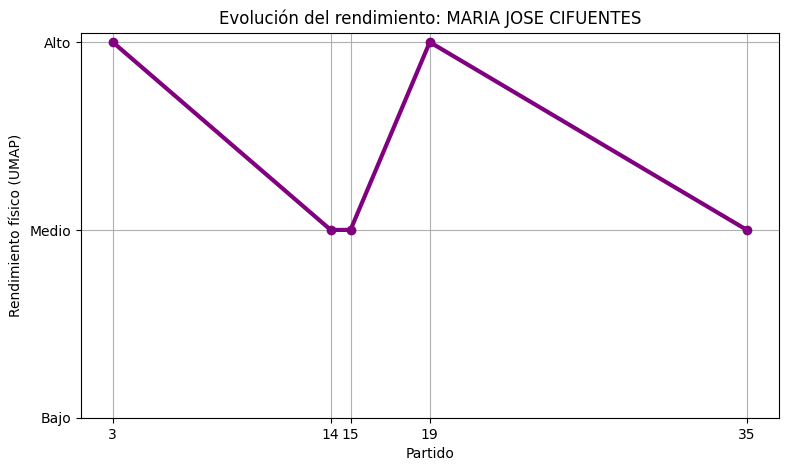

In [194]:
graficar_evolucion("MARIA JOSE CIFUENTES")


In [195]:
resumen = matches_ordenado.groupby("player_name_clean").agg(
    primero=("nivel_num", "first"),
    ultimo=("nivel_num", "last"),
    max_rend=("nivel_num", "max"),
    min_rend=("nivel_num", "min"),
    partidos=("nivel_num", "count")
)

resumen["cambio_total"] = resumen["ultimo"] - resumen["primero"]

resumen


,primero,ultimo,max_rend,min_rend,partidos,cambio_total
player_name_clean,,,,,,
ANDREA JULIETH SOSA RODRIGUEZ,1,2,2,0,3,1
CARLOS FELIPE ANDRADE SAENZ,1,0,1,0,3,-1
CESAR CAMILO DIAZ CUFINO,2,1,2,1,2,-1
CRISTIAN STEVAN SOTO ZAPATA,0,0,1,0,3,0
DAVID SANTIAGO MEDINA BUITRAGO,2,0,2,0,3,-2
DAVID SANTIAGO MURCIA BARRERA,1,1,2,1,3,0
FERMIN ALEJANDRO ESCALONA GUILLEN,2,2,2,2,1,0
ISABELLA BUITRAGO HURTADO,0,1,1,0,3,1
JAIME ANDRES CASTILLO ALVAREZ,1,0,1,0,2,-1
